# Backtesting Crossover Strategies on Hourly datasets for Ether and BTC

## 1. Preparations:

In [90]:
# imports
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import matplotlib.pyplot as plt
import pandas as pd

import datetime  # For datetime objects
import pprint
import itertools

import backtrader as bt

from binance.client import Client
from klychi import api_key, api_secret

client = Client(api_key, api_secret)

# to display all of the columns and rows and max width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# to solve issue of bt plot not showing after re-running the cell
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'  # improves the quality of graphs

# set size for plots (width, height)
plt.rcParams['figure.figsize'] = [20, 15]
plt.style.use('ggplot')

In [88]:
def organise_binance_klines(df, save_csv=False, csv_name=''):
    col_names = ['open_time_unix', 'open', 'high', 'low', 'close', 'volume', 
                 'close_time_unix', 'quote_asset_volume', 'number_of_trades', 
                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df_new = df.copy()
    
    # change unix time to datetime; binance show time in ms
    df_new['candle-start'] = pd.to_datetime(df_new[0], unit='ms')
    df_new['candle-end'] = pd.to_datetime(df_new[6], unit='ms')
    
    # rename columns
    df_new.columns = col_names + ['candle-start', 'candle-end']
    
    # set index and drop extra columns
    df_new.set_index(['candle-end'], inplace=True)
    
    # change dtypes of data from object to float/int
    df_new = df_new.astype({'open': 'float64', 'high': 'float64', 'low': 'float64', 'close': 'float64',
                            'volume': 'float64','quote_asset_volume': 'float64', 'number_of_trades': 'int64',
                            'taker_buy_base_asset_volume': 'float64', 
                            'taker_buy_quote_asset_volume': 'float64'})
    
    if save_csv:
        df_new.to_csv(path_or_buf=str(csv_name) + '.csv')
    
    return df_new


def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total, 2)
    strike_rate = round(number=((total_won / total_closed) * 100), ndigits=2)
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate %','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))


def printDrawDown(analyzer):
    '''
    Function to print the DrawDown results in a nice format.
    '''
    ddpct = round(analyzer.drawdown, 2)
    moneydd = round(analyzer.moneydown, 2)
    ddlen = analyzer.len
    maxdd = round(analyzer.max.drawdown, 2)
    maxmoneydd = round(analyzer.max.moneydown, 2)
    maxddlen = analyzer.max.len
    
    # Designate the rows
    h1 = ['DrawDown %', 'Money Down $', 'DrawDown Length']
    h2 = ['Max DrawDown %','Max MoneyDown $ ', 'Max DrawDown Length']
    r1 = [ddpct, moneydd, ddlen]
    r2 = [maxdd, maxmoneydd, maxddlen]
    
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("DrawDown Results:")
    for row in print_list:
        print(row_format.format('',*row))



# 2. ETHER

# 2.1 Download and organise data from Binance (ETH / USDT) 1 hour candles

In [3]:
# download data (might take a minute)
# ETH/USDT pair at 1 hour granularity
eth_usdt1h_raw = pd.DataFrame(client.get_historical_klines("ETHUSDT", 
                                                           Client.KLINE_INTERVAL_1HOUR, 
                                                           '1 Jan 2017'))

In [4]:
# organise eth/usdt data
eth_usdt1h = organise_binance_klines(eth_usdt1h_raw, save_csv=True, csv_name='eth_usdt1h')

# describe downloaded data
eth_usdt1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17507 entries, 2017-08-17 04:59:59.999000 to 2019-08-20 10:59:59.999000
Data columns (total 13 columns):
open_time_unix                  17507 non-null int64
open                            17507 non-null float64
high                            17507 non-null float64
low                             17507 non-null float64
close                           17507 non-null float64
volume                          17507 non-null float64
close_time_unix                 17507 non-null int64
quote_asset_volume              17507 non-null float64
number_of_trades                17507 non-null int64
taker_buy_base_asset_volume     17507 non-null float64
taker_buy_quote_asset_volume    17507 non-null float64
ignore                          17507 non-null object
candle-start                    17507 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 1.9+ MB


In [5]:
eth_usdt1h.head()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,candle-start
candle-end,,,,,,,,,,,,,
2017-08-17 04:59:59.999,1502942400000,301.13,302.57,298.0,301.61,125.66877,1502945999999,37684.804181,129,80.56377,24193.440789,47039.70675719,2017-08-17 04:00:00
2017-08-17 05:59:59.999,1502946000000,301.61,303.28,300.0,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,47250.80517462,2017-08-17 05:00:00
2017-08-17 06:59:59.999,1502949600000,302.40,304.44,301.9,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,47176.44458354,2017-08-17 06:00:00
2017-08-17 07:59:59.999,1502953200000,302.68,307.96,302.6,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,46884.54339102,2017-08-17 07:00:00
2017-08-17 08:59:59.999,1502956800000,307.95,309.97,307.0,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,46771.05734185,2017-08-17 08:00:00


In [6]:
eth_usdt1h.describe()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.750700e+04,17507.000000,17507.000000,17507.000000,17507.000000,17507.000000,1.750700e+04,1.750700e+04,17507.000000,17507.000000,1.750700e+04
mean,1.534629e+12,370.215390,373.572443,366.573140,370.200253,10535.052305,1.534633e+12,2.864294e+06,5263.460616,5381.139980,1.457436e+06
std,1.828911e+10,255.859765,259.127989,252.119987,255.849077,13830.157380,1.828911e+10,3.311684e+06,4814.887816,7016.695492,1.665804e+06
min,1.502942e+12,82.160000,82.950000,81.790000,82.170000,0.000000,1.502946e+12,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.518842e+12,187.980000,189.825000,186.000000,188.025000,2672.038015,1.518845e+12,8.622472e+05,2461.000000,1312.728990,4.281757e+05
50%,1.534662e+12,289.920000,292.060000,287.550000,289.930000,6352.422600,1.534666e+12,1.979003e+06,4205.000000,3224.739340,1.000767e+06
75%,1.550453e+12,473.695000,477.160000,470.300000,473.675000,13110.855210,1.550457e+12,3.710602e+06,6740.000000,6748.741410,1.918249e+06
max,1.566295e+12,1431.010000,1440.000000,1395.780000,1431.010000,279023.454890,1.566299e+12,4.474518e+07,67360.000000,121053.794110,2.239968e+07


## 2.2 Lets see how the downloaded data looks like

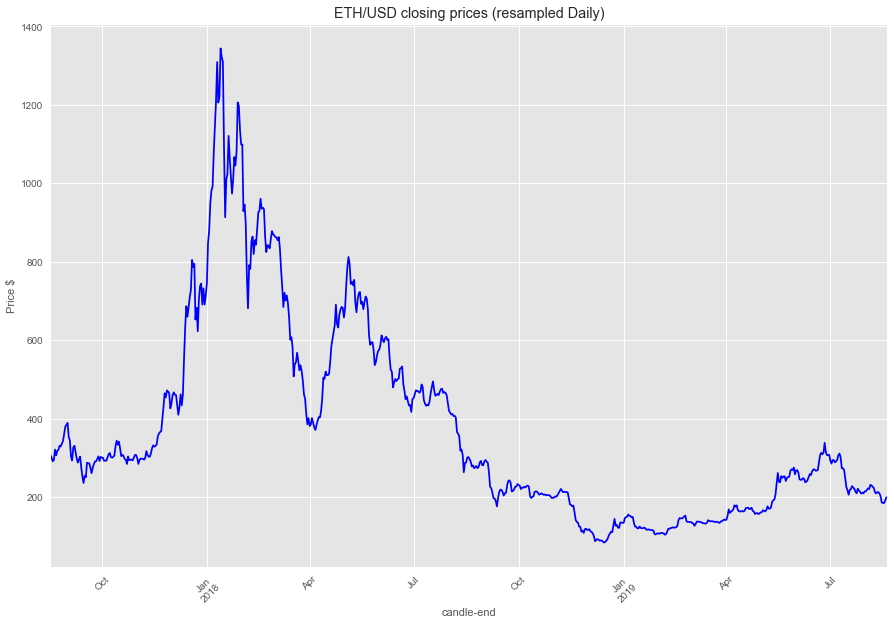

In [86]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=11)
ax1.set_ylabel(ylabel='Price $', fontsize=11)

# data is in hourly resolution, so resampling it in daily format to smooth graph
eth_usdt1h['close'].resample('D').mean().plot(ax=ax1, color='blue')

plt.title('ETH/USD closing prices (resampled Daily)')

plt.xticks(rotation=45)

plt.show()

# 2.3 EMA and Price Crossover Backtest on ETH / USDT

Starting Portfolio Value: 10000.00
2017-08-20T19:59:59.998997, BUY CREATE , 297.88
2017-08-20T20:59:59.999004, BUY EXECUTED, Price: 297.87, Cost: 500.42, Comm 0.50
2017-08-20T20:59:59.999004, Trade id: 25346
2017-08-22T01:59:59.998997, CLOSE LONG , 309.97 , Wait for Short
2017-08-22T02:59:59.999004, SELL EXECUTED, Price: 309.96, Cost: 500.42, Comm 0.55
2017-08-22T02:59:59.999004, OPERATION PROFIT, GROSS 203.11, NET 202.06, Acc Balance: 10202.06
2017-08-22T05:59:59.999004, SELL CREATE , 279.96
2017-08-22T06:59:59.999000, SELL EXECUTED, Price: 302.99, Cost: -542.35, Comm 0.54
2017-08-22T06:59:59.999000, Trade id: 25347
2017-08-22T10:59:59.998997, CLOSE SHORT , 310.24 , Wait for Long
2017-08-22T11:59:59.999004, BUY EXECUTED, Price: 309.40, Cost: -542.35, Comm 0.55
2017-08-22T11:59:59.999004, OPERATION PROFIT, GROSS -114.74, NET -115.84, Acc Balance: 10086.23
2017-08-22T17:59:59.999004, BUY CREATE , 312.07
2017-08-22T18:59:59.999000, BUY EXECUTED, Price: 313.99, Cost: 502.38, Comm 0.50
201

2017-11-10T11:59:59.999004, CLOSE LONG , 311.56 , Wait for Short
2017-11-10T12:59:59.999000, SELL EXECUTED, Price: 311.03, Cost: 472.96, Comm 0.52
2017-11-10T12:59:59.999000, OPERATION PROFIT, GROSS 215.76, NET 214.77, Acc Balance: 9688.05
2017-11-10T15:59:59.999000, SELL CREATE , 301.00
2017-11-10T16:59:59.998997, SELL EXECUTED, Price: 300.98, Cost: -484.58, Comm 0.48
2017-11-10T16:59:59.998997, Trade id: 25383
2017-11-11T17:59:59.999004, CLOSE SHORT , 306.25 , Wait for Long
2017-11-11T18:59:59.999000, BUY EXECUTED, Price: 309.86, Cost: -484.58, Comm 0.51
2017-11-11T18:59:59.999000, OPERATION PROFIT, GROSS -142.97, NET -143.96, Acc Balance: 9544.09
2017-11-11T21:59:59.999000, BUY CREATE , 311.79
2017-11-11T22:59:59.998997, BUY EXECUTED, Price: 311.78, Cost: 477.02, Comm 0.48
2017-11-11T22:59:59.998997, Trade id: 25384
2017-11-12T01:59:59.998997, CLOSE LONG , 302.50 , Wait for Short
2017-11-12T02:59:59.999004, SELL EXECUTED, Price: 302.49, Cost: 477.02, Comm 0.48
2017-11-12T02:59:59.99

2018-02-23T07:59:59.998997, CLOSE SHORT , 837.83 , Wait for Long
2018-02-23T08:59:59.999004, BUY EXECUTED, Price: 837.83, Cost: -465.79, Comm 0.46
2018-02-23T08:59:59.999004, OPERATION PROFIT, GROSS 468.75, NET 467.83, Acc Balance: 9700.80
2018-02-23T14:59:59.999004, BUY CREATE , 869.40
2018-02-23T15:59:59.999000, BUY EXECUTED, Price: 869.45, Cost: 486.89, Comm 0.49
2018-02-23T15:59:59.999000, Trade id: 25426
2018-02-23T16:59:59.998997, CLOSE LONG , 841.98 , Wait for Short
2018-02-23T17:59:59.999004, SELL EXECUTED, Price: 842.45, Cost: 486.89, Comm 0.47
2018-02-23T17:59:59.999004, OPERATION PROFIT, GROSS -151.20, NET -152.16, Acc Balance: 9548.64
2018-02-23T21:59:59.999000, SELL CREATE , 829.89
2018-02-23T22:59:59.998997, SELL EXECUTED, Price: 829.40, Cost: -481.05, Comm 0.48
2018-02-23T22:59:59.998997, Trade id: 25427
2018-02-23T22:59:59.998997, CLOSE SHORT , 854.00 , Wait for Long
2018-02-23T23:59:59.999004, BUY EXECUTED, Price: 854.11, Cost: -481.05, Comm 0.50
2018-02-23T23:59:59.99

2018-05-13T09:59:59.999000, CLOSE SHORT , 698.50 , Wait for Long
2018-05-13T10:59:59.998997, BUY EXECUTED, Price: 698.50, Cost: -449.25, Comm 0.46
2018-05-13T10:59:59.998997, OPERATION PROFIT, GROSS 231.68, NET 230.77, Acc Balance: 9151.40
2018-05-13T14:59:59.999004, BUY CREATE , 722.25
2018-05-13T15:59:59.999000, BUY EXECUTED, Price: 722.50, Cost: 455.18, Comm 0.46
2018-05-13T15:59:59.999000, Trade id: 25458
2018-05-14T03:59:59.999000, CLOSE LONG , 696.00 , Wait for Short
2018-05-14T04:59:59.998997, SELL EXECUTED, Price: 696.00, Cost: 455.18, Comm 0.45
2018-05-14T04:59:59.998997, OPERATION PROFIT, GROSS -166.95, NET -167.86, Acc Balance: 8983.54
2018-05-15T22:59:59.998997, SELL CREATE , 699.67
2018-05-15T23:59:59.999004, SELL EXECUTED, Price: 700.28, Cost: -448.18, Comm 0.45
2018-05-15T23:59:59.999004, Trade id: 25459
2018-05-16T23:59:59.999004, CLOSE SHORT , 706.29 , Wait for Long
2018-05-17T00:59:59.999000, BUY EXECUTED, Price: 706.80, Cost: -448.18, Comm 0.48
2018-05-17T00:59:59.99

2018-08-04T02:59:59.999004, BUY CREATE , 418.87
2018-08-04T03:59:59.999000, BUY EXECUTED, Price: 418.93, Cost: 498.53, Comm 0.50
2018-08-04T03:59:59.999000, Trade id: 25492
2018-08-04T10:59:59.998997, CLOSE LONG , 414.58 , Wait for Short
2018-08-04T11:59:59.999004, SELL EXECUTED, Price: 414.63, Cost: 498.53, Comm 0.49
2018-08-04T11:59:59.999004, OPERATION PROFIT, GROSS -51.17, NET -52.16, Acc Balance: 10625.73
2018-08-04T12:59:59.999000, SELL CREATE , 408.29
2018-08-04T13:59:59.998997, SELL EXECUTED, Price: 408.29, Cost: -498.11, Comm 0.50
2018-08-04T13:59:59.998997, Trade id: 25493
2018-08-05T20:59:59.999004, CLOSE SHORT , 411.57 , Wait for Long
2018-08-05T21:59:59.999000, BUY EXECUTED, Price: 411.95, Cost: -498.11, Comm 0.52
2018-08-05T21:59:59.999000, OPERATION PROFIT, GROSS -44.65, NET -45.67, Acc Balance: 10580.06
2018-08-06T05:59:59.999004, BUY CREATE , 410.76
2018-08-06T06:59:59.999000, BUY EXECUTED, Price: 411.09, Cost: 501.53, Comm 0.50
2018-08-06T06:59:59.999000, Trade id: 25

2018-10-31T15:59:59.999000, CLOSE SHORT , 199.36 , Wait for Long
2018-10-31T16:59:59.998997, BUY EXECUTED, Price: 199.60, Cost: -466.22, Comm 0.50
2018-10-31T16:59:59.998997, OPERATION PROFIT, GROSS -48.38, NET -49.34, Acc Balance: 9273.56
2018-11-01T05:59:59.999004, BUY CREATE , 198.43
2018-11-01T06:59:59.999000, BUY EXECUTED, Price: 198.43, Cost: 464.33, Comm 0.46
2018-11-01T06:59:59.999000, Trade id: 25534
2018-11-03T09:59:59.999000, CLOSE LONG , 199.95 , Wait for Short
2018-11-03T10:59:59.998997, SELL EXECUTED, Price: 199.94, Cost: 464.33, Comm 0.49
2018-11-03T10:59:59.998997, OPERATION PROFIT, GROSS 35.33, NET 34.38, Acc Balance: 9307.94
2018-11-03T17:59:59.999004, SELL CREATE , 199.98
2018-11-03T18:59:59.999000, SELL EXECUTED, Price: 199.98, Cost: -465.95, Comm 0.47
2018-11-03T18:59:59.999000, Trade id: 25535
2018-11-03T20:59:59.999004, CLOSE SHORT , 200.68 , Wait for Long
2018-11-03T21:59:59.999000, BUY EXECUTED, Price: 200.62, Cost: -465.95, Comm 0.47
2018-11-03T21:59:59.999000

2019-01-26T10:59:59.998997, BUY CREATE , 116.42
2019-01-26T11:59:59.999004, BUY EXECUTED, Price: 116.42, Cost: 373.71, Comm 0.37
2019-01-26T11:59:59.999004, Trade id: 25566
2019-01-26T15:59:59.999000, CLOSE LONG , 115.45 , Wait for Short
2019-01-26T16:59:59.998997, SELL EXECUTED, Price: 115.45, Cost: 373.71, Comm 0.37
2019-01-26T16:59:59.998997, OPERATION PROFIT, GROSS -31.14, NET -31.88, Acc Balance: 7445.84
2019-01-26T19:59:59.998997, SELL CREATE , 115.64
2019-01-26T20:59:59.999004, SELL EXECUTED, Price: 115.63, Cost: -372.33, Comm 0.37
2019-01-26T20:59:59.999004, Trade id: 25567
2019-01-30T12:59:59.999000, CLOSE SHORT , 107.67 , Wait for Long
2019-01-30T13:59:59.998997, BUY EXECUTED, Price: 107.64, Cost: -372.33, Comm 0.39
2019-01-30T13:59:59.998997, OPERATION PROFIT, GROSS 257.28, NET 256.52, Acc Balance: 7702.36
2019-01-30T14:59:59.999004, BUY CREATE , 108.94
2019-01-30T15:59:59.999000, BUY EXECUTED, Price: 108.95, Cost: 385.68, Comm 0.39
2019-01-30T15:59:59.999000, Trade id: 2556

2019-04-14T13:59:59.998997, CLOSE SHORT , 163.51 , Wait for Long
2019-04-14T14:59:59.999004, BUY EXECUTED, Price: 163.56, Cost: -386.60, Comm 0.41
2019-04-14T14:59:59.999004, OPERATION PROFIT, GROSS 120.45, NET 119.66, Acc Balance: 7858.10
2019-04-14T22:59:59.998997, BUY CREATE , 167.42
2019-04-14T23:59:59.999004, BUY EXECUTED, Price: 167.36, Cost: 393.30, Comm 0.39
2019-04-14T23:59:59.999004, Trade id: 25596
2019-04-15T10:59:59.998997, CLOSE LONG , 164.81 , Wait for Short
2019-04-15T11:59:59.999004, SELL EXECUTED, Price: 164.80, Cost: 393.30, Comm 0.40
2019-04-15T11:59:59.999004, OPERATION PROFIT, GROSS -60.16, NET -60.95, Acc Balance: 7797.15
2019-04-15T18:59:59.999000, SELL CREATE , 160.24
2019-04-15T19:59:59.998997, SELL EXECUTED, Price: 160.23, Cost: -389.36, Comm 0.39
2019-04-15T19:59:59.998997, Trade id: 25597
2019-04-16T09:59:59.999000, CLOSE SHORT , 163.30 , Wait for Long
2019-04-16T10:59:59.998997, BUY EXECUTED, Price: 163.30, Cost: -389.36, Comm 0.41
2019-04-16T10:59:59.9989

2019-07-02T17:59:59.999004, CLOSE SHORT , 291.04 , Wait for Long
2019-07-02T18:59:59.999000, BUY EXECUTED, Price: 291.02, Cost: -371.50, Comm 0.38
2019-07-02T18:59:59.999000, OPERATION PROFIT, GROSS 77.25, NET 76.49, Acc Balance: 7524.07
2019-07-03T05:59:59.999004, BUY CREATE , 297.58
2019-07-03T06:59:59.999000, BUY EXECUTED, Price: 297.59, Cost: 374.96, Comm 0.37
2019-07-03T06:59:59.999000, Trade id: 25628
2019-07-03T08:59:59.999004, CLOSE LONG , 290.80 , Wait for Short
2019-07-03T09:59:59.999000, SELL EXECUTED, Price: 290.80, Cost: 374.96, Comm 0.37
2019-07-03T09:59:59.999000, OPERATION PROFIT, GROSS -85.55, NET -86.30, Acc Balance: 7437.77
2019-07-04T23:59:59.999004, SELL CREATE , 282.73
2019-07-05T00:59:59.999000, SELL EXECUTED, Price: 282.86, Cost: -373.38, Comm 0.37
2019-07-05T00:59:59.999000, Trade id: 25629
2019-07-05T10:59:59.998997, CLOSE SHORT , 293.54 , Wait for Long
2019-07-05T11:59:59.999004, BUY EXECUTED, Price: 293.41, Cost: -373.38, Comm 0.39
2019-07-05T11:59:59.999004

<IPython.core.display.Javascript object>


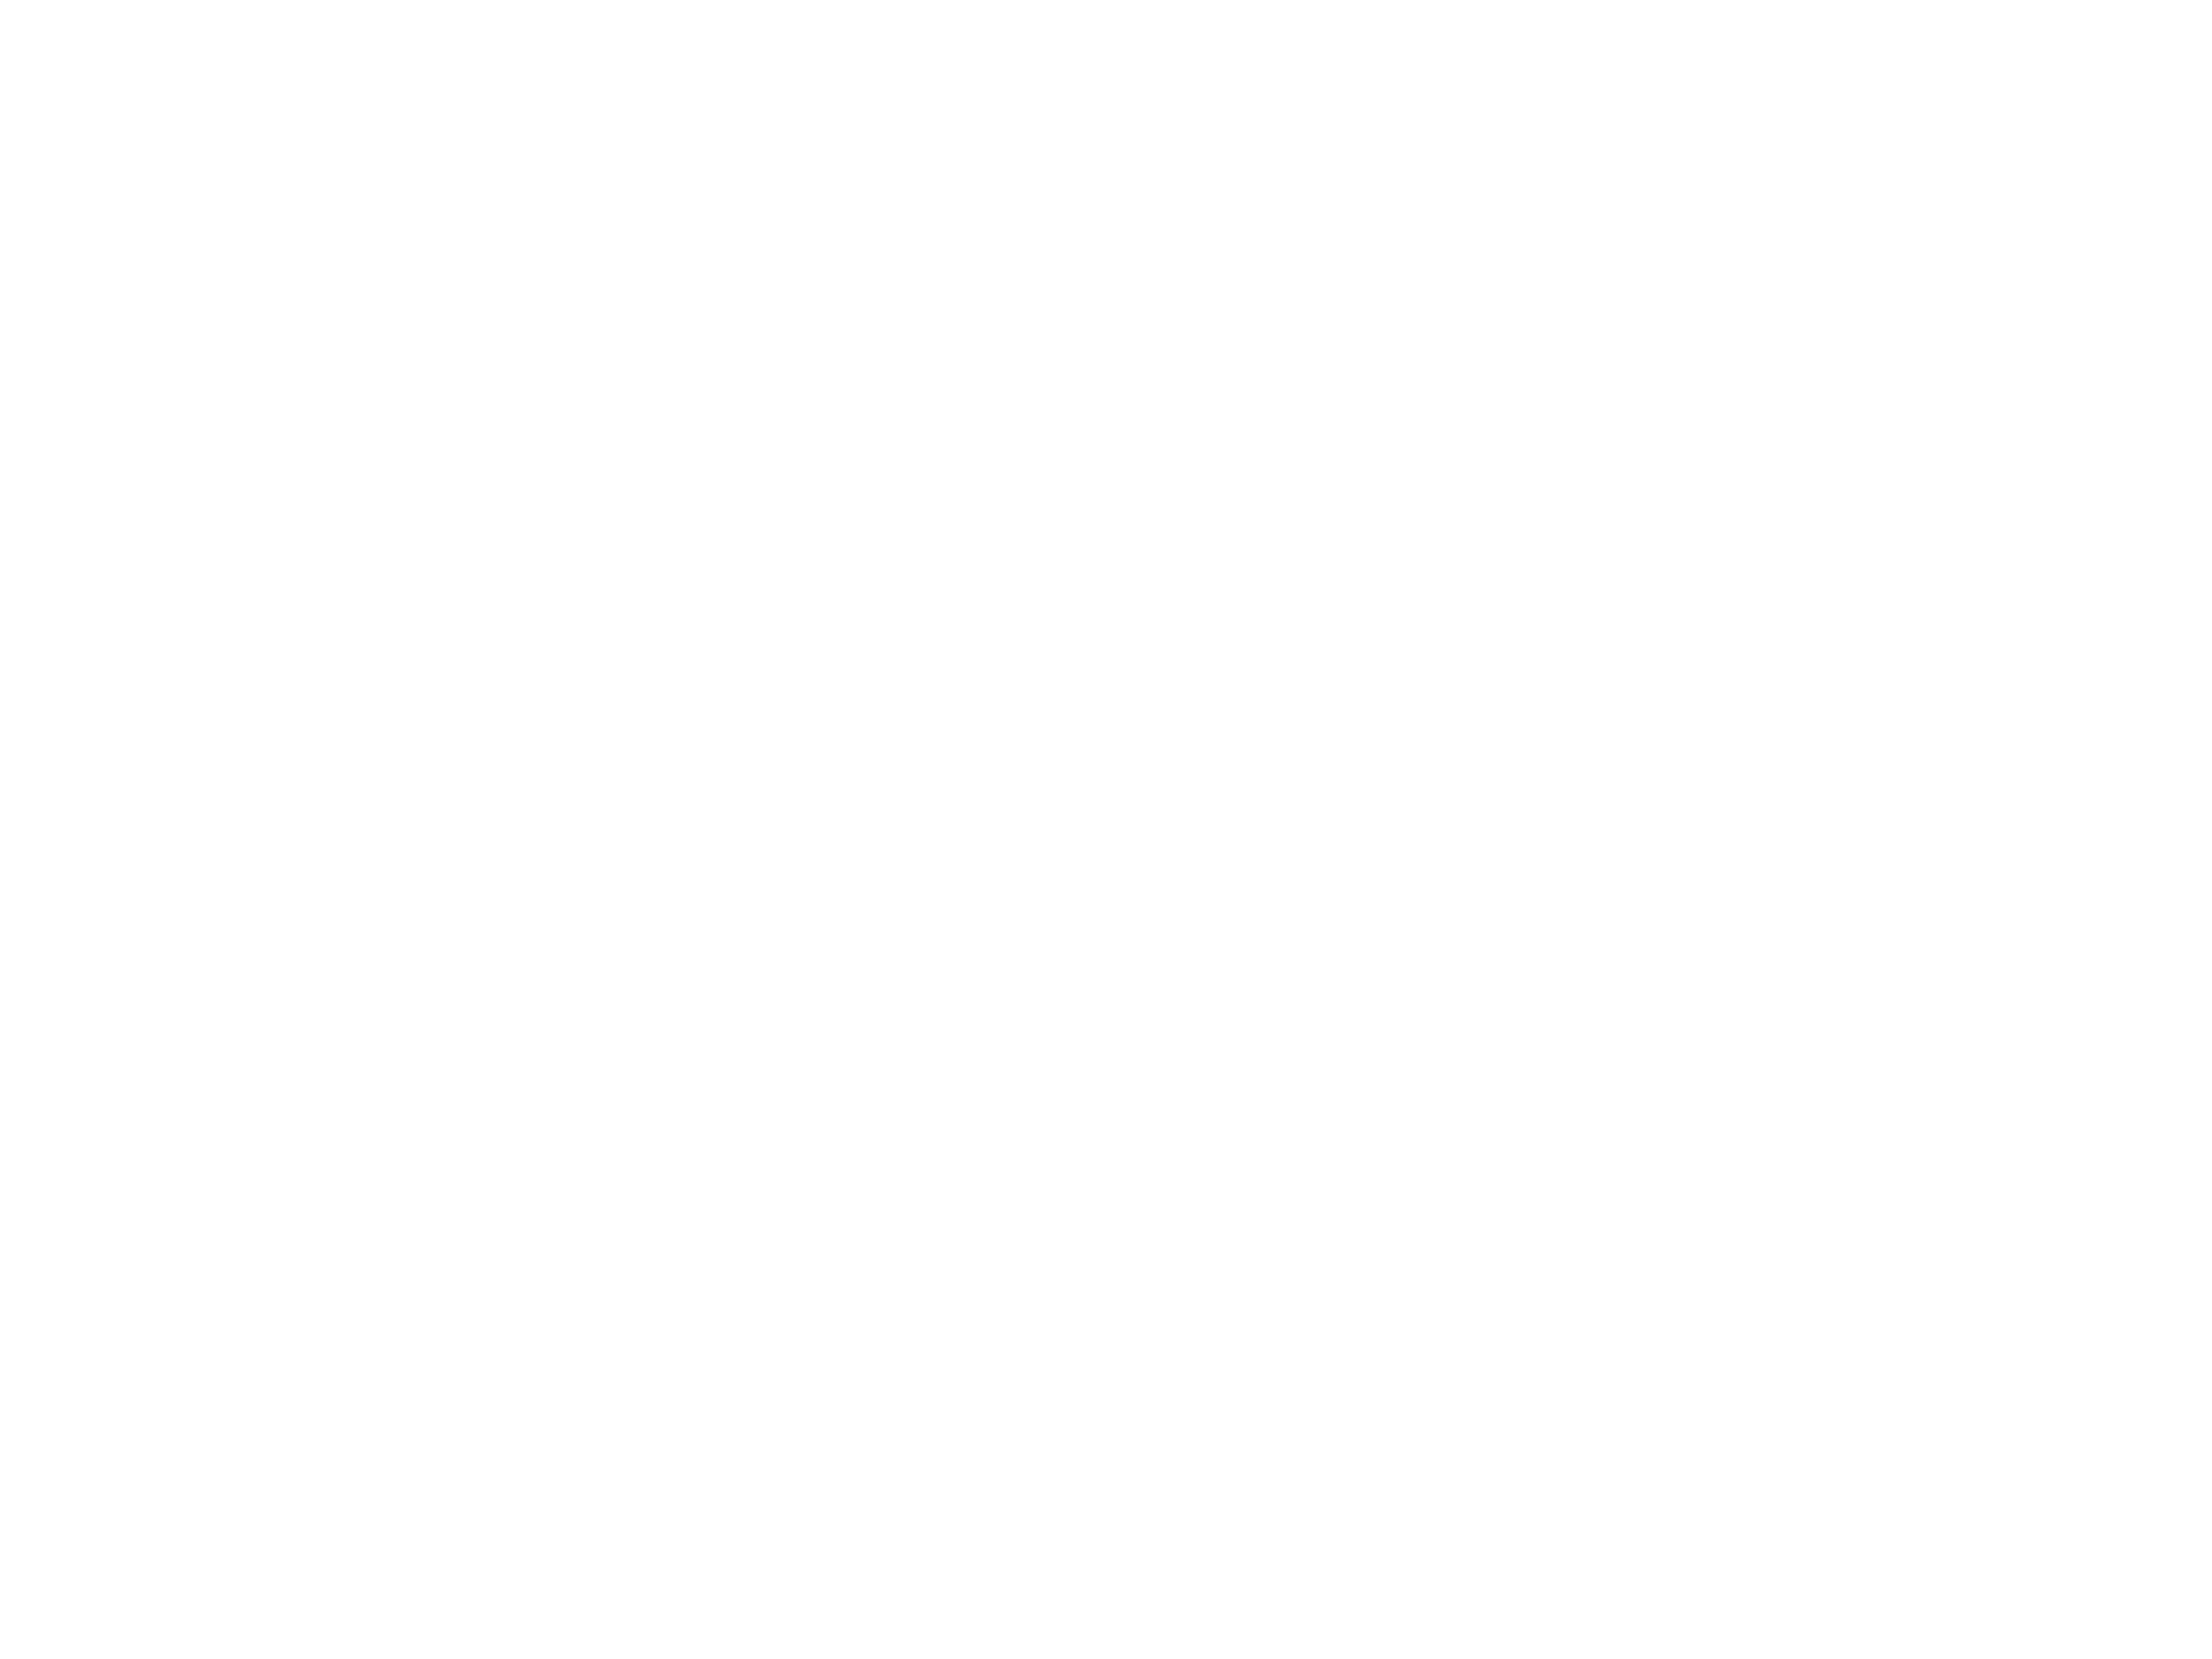

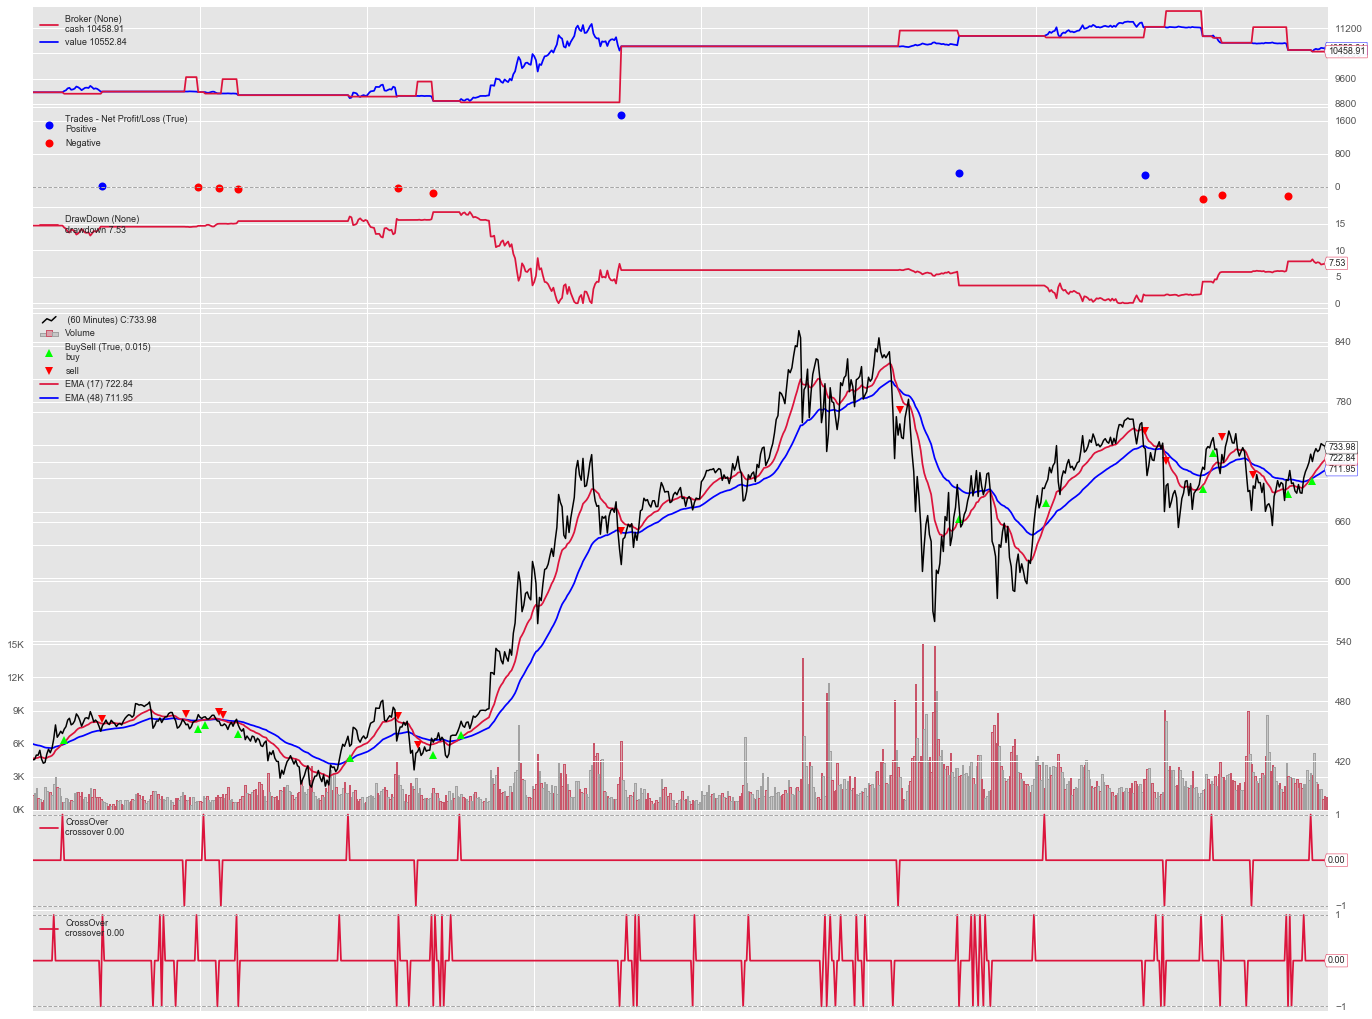

In [91]:
# EMA AND Price Crossover

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),  # multiply profits and loses (margin trading)
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )
    


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)
        self.pricecrossover = bt.ind.CrossOver(self.datas[0].close, ema_long)
        
        self.wait_to_enter = ''


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        # if an order is active, no new orders are allowed
        if self.order:
            return   
        
        # if position is not opened
        if not self.position:
            
            # if signal is go long - cross upwards
            if self.crossover > 0:
                
                # if we are waiting for a Short signal
                if self.wait_to_enter == 'wait_for_short':
                    return
                
                else: # BUY BUY BUY
                    self.log('BUY CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.buy(size=round(min((cerebro.broker.getvalue()*0.05),
                                                         500) / self.dataclose[0], 2))
                            # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
            
            # if signal is go short - cross downwards
            elif self.crossover < 0:
                
                # if we are waiting for a Long signal
                if self.wait_to_enter == 'wait_for_long':
                    return

                else:  # SELL SELL SELL
                    self.log('SELL CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.sell(size=round(min((cerebro.broker.getvalue()*0.05),
                                             500) / self.dataclose[0], 2))
                             # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
        
        # if we are in the market:
        elif self.position:
            # if price signals close short == -1
            if self.pricecrossover > 0:
                self.log('CLOSE SHORT , %.2f , Wait for Long' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_long'
                self.order = self.close()
            
            # if price signals close long == 1
            elif self.pricecrossover < 0:
                self.log('CLOSE LONG , %.2f , Wait for Short' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_short'
                self.order = self.close()
                
                
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isopen:
            self.log('Trade id: {}'.format(trade.ref))
        
        elif trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 1, 1), 
                 plotname='ETH/USDT 1h EMA and Price Crossover, 2017_08-2019_08',
                savefig=True)
    
    # cerebro.plot()  # plot backtest

# 2.4 Optimise parameters for EMA and Price Crossover

#### Short EMA (15-20), Long EMA (45-50)

In [92]:
# Parameter optimisation for EMA and Price Crossover

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', False),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)
        self.pricecrossover = bt.ind.CrossOver(self.datas[0].close, ema_long)
        
        self.wait_to_enter = ''


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        # if an order is active, no new orders are allowed
        if self.order:
            return   
        
        # if position is not opened
        if not self.position:
            
            # if signal is go long - cross upwards
            if self.crossover > 0:
                
                # if we are waiting for a Short signal
                if self.wait_to_enter == 'wait_for_short':
                    return
                
                else: # BUY BUY BUY
                    self.log('BUY CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.buy(size=round(min((cerebro.broker.getvalue()*0.05),
                                                         500) / self.dataclose[0], 2))
                            # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
            
            # if signal is go short - cross downwards
            elif self.crossover < 0:
                
                # if we are waiting for a Long signal
                if self.wait_to_enter == 'wait_for_long':
                    return

                else:  # SELL SELL SELL
                    self.log('SELL CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.sell(size=round(min((cerebro.broker.getvalue()*0.05),
                                             500) / self.dataclose[0], 2))
                             # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
        
        # if we are in the market:
        elif self.position:
            # if price signals close short == -1
            if self.pricecrossover > 0:
                self.log('CLOSE SHORT , %.2f , Wait for Long' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_long'
                self.order = self.close()
            
            # if price signals close long == 1
            elif self.pricecrossover < 0:
                self.log('CLOSE LONG , %.2f , Wait for Short' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_short'
                self.order = self.close()


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))
    
    
#     UNCOMMENT TO OPTIMISE
    def stop(self):
        self.log('(Short EMA %2d), (Long EMA: %2d) Ending Value %.2f' %
                 (self.params.short_ema, self.params.long_ema, self.broker.getvalue()),
                 doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        short_ema=range(15, 21),
        long_ema=range(45, 51))
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Add a Percentage sizer - set to 5% of portfolio value
    # cerebro.addsizer(bt.sizers.PercentSizer, percents=5)
    # cerebro.addsizer(bt.sizers.FixedSize)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Run over everything
    thestrats = cerebro.run(maxcpus=2)  # OPTIMIZE
    thestrat = thestrats[0]


Starting Portfolio Value: 10000.00
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 45) Ending Value 9832.55
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 46) Ending Value 9527.77
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 47) Ending Value 8967.69
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 48) Ending Value 8177.19
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 49) Ending Value 9337.50
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 50) Ending Value 9502.95
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 45) Ending Value 7142.71
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 46) Ending Value 7812.72
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 47) Ending Value 8627.72
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 48) Ending Value 9634.23
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 49) Ending Value 8604.00
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 50) Ending Value 9877.43
2019-

# Parameter optimisation didn't improve returns, larger ranges could be tried

# 2.5 Simple EMA crossover strategy for Ether

Starting Portfolio Value: 10000.00
2017-08-20T19:59:59.998997, BUY CREATE , 297.88
2017-08-20T20:59:59.999004, BUY EXECUTED, Price: 297.87, Cost: 500.42, Comm 0.50
2017-08-20T20:59:59.999004, TRADE OPENED, SIZE:  1 , VAL: 500.42
2017-08-22T05:59:59.999004, CLOSE LONG , 279.96
2017-08-22T05:59:59.999004, SELL CREATE , 279.96
2017-08-22T06:59:59.999000, SELL EXECUTED, Price: 302.99, Cost: 500.42, Comm 0.54
2017-08-22T06:59:59.999000, SELL EXECUTED, Price: 302.99, Cost: -527.20, Comm 0.53
2017-08-22T06:59:59.999000, OPERATION PROFIT, GROSS 86.02, NET 84.98, Acc Balance: 10080.31
2017-08-22T06:59:59.999000, TRADE OPENED, SIZE: -1 , VAL: -527.20
2017-08-22T17:59:59.999004, CLOSE SHORT , 312.07
2017-08-22T17:59:59.999004, BUY CREATE , 312.07
2017-08-22T18:59:59.999000, BUY EXECUTED, Price: 313.99, Cost: -527.20, Comm 0.55
2017-08-22T18:59:59.999000, BUY EXECUTED, Price: 313.99, Cost: 502.38, Comm 0.50
2017-08-22T18:59:59.999000, OPERATION PROFIT, GROSS -191.40, NET -192.47, Acc Balance: 9845

2017-11-03T14:59:59.999004, CLOSE SHORT , 296.79
2017-11-03T14:59:59.999004, BUY CREATE , 296.79
2017-11-03T15:59:59.999000, BUY EXECUTED, Price: 297.58, Cost: -439.07, Comm 0.45
2017-11-03T15:59:59.999000, BUY EXECUTED, Price: 297.58, Cost: 440.42, Comm 0.44
2017-11-03T15:59:59.999000, OPERATION PROFIT, GROSS 105.55, NET 104.66, Acc Balance: 8868.12
2017-11-03T15:59:59.999000, TRADE OPENED, SIZE:  1 , VAL: 440.42
2017-11-05T19:59:59.998997, CLOSE LONG , 294.17
2017-11-05T19:59:59.998997, SELL CREATE , 294.17
2017-11-05T20:59:59.999004, SELL EXECUTED, Price: 294.07, Cost: 440.42, Comm 0.46
2017-11-05T20:59:59.999004, SELL EXECUTED, Price: 294.07, Cost: -441.11, Comm 0.44
2017-11-05T20:59:59.999004, OPERATION PROFIT, GROSS -51.95, NET -52.85, Acc Balance: 8820.09
2017-11-05T20:59:59.999004, TRADE OPENED, SIZE: -1 , VAL: -441.11
2017-11-06T12:59:59.999000, CLOSE SHORT , 301.06
2017-11-06T12:59:59.999000, BUY CREATE , 301.06
2017-11-06T13:59:59.998997, BUY EXECUTED, Price: 301.08, Cost: -

2018-01-30T02:59:59.999004, CLOSE LONG , 1148.10
2018-01-30T02:59:59.999004, SELL CREATE , 1148.10
2018-01-30T03:59:59.999000, SELL EXECUTED, Price: 1148.10, Cost: 495.85, Comm 0.58
2018-01-30T03:59:59.999000, SELL EXECUTED, Price: 1148.10, Cost: -505.16, Comm 0.51
2018-01-30T03:59:59.999000, OPERATION PROFIT, GROSS 437.57, NET 436.49, Acc Balance: 12353.96
2018-01-30T03:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -505.16
2018-02-01T04:59:59.998997, CLOSE SHORT , 1152.51
2018-02-01T04:59:59.998997, BUY CREATE , 1152.51
2018-02-01T05:59:59.999004, BUY EXECUTED, Price: 1152.51, Cost: -505.16, Comm 0.53
2018-02-01T05:59:59.999004, BUY EXECUTED, Price: 1152.51, Cost: 495.58, Comm 0.50
2018-02-01T05:59:59.999004, OPERATION PROFIT, GROSS -19.40, NET -20.44, Acc Balance: 12354.27
2018-02-01T05:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 495.58
2018-02-01T10:59:59.998997, CLOSE LONG , 1096.00
2018-02-01T10:59:59.998997, SELL CREATE , 1096.00
2018-02-01T11:59:59.999004, SELL EXECUTED, Price: 10

2018-03-10T07:59:59.998997, CLOSE SHORT , 729.19
2018-03-10T07:59:59.998997, BUY CREATE , 729.19
2018-03-10T08:59:59.999004, BUY EXECUTED, Price: 729.26, Cost: -496.34, Comm 0.49
2018-03-10T08:59:59.999004, BUY EXECUTED, Price: 729.26, Cost: 503.19, Comm 0.50
2018-03-10T08:59:59.999004, OPERATION PROFIT, GROSS 733.70, NET 732.71, Acc Balance: 13273.93
2018-03-10T08:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 503.19
2018-03-10T20:59:59.999004, CLOSE LONG , 688.99
2018-03-10T20:59:59.999004, SELL CREATE , 688.99
2018-03-10T21:59:59.999000, SELL EXECUTED, Price: 688.98, Cost: 503.19, Comm 0.48
2018-03-10T21:59:59.999000, SELL EXECUTED, Price: 688.98, Cost: -502.96, Comm 0.50
2018-03-10T21:59:59.999000, OPERATION PROFIT, GROSS -277.93, NET -278.91, Acc Balance: 13000.92
2018-03-10T21:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -502.96
2018-03-11T19:59:59.998997, CLOSE SHORT , 729.20
2018-03-11T19:59:59.998997, BUY CREATE , 729.20
2018-03-11T20:59:59.999004, BUY EXECUTED, Price: 729.20, Cos

2018-04-25T10:59:59.998997, CLOSE LONG , 621.73
2018-04-25T10:59:59.998997, SELL CREATE , 621.73
2018-04-25T11:59:59.999004, SELL EXECUTED, Price: 621.73, Cost: 498.97, Comm 0.70
2018-04-25T11:59:59.999004, SELL EXECUTED, Price: 621.73, Cost: -497.38, Comm 0.50
2018-04-25T11:59:59.999004, OPERATION PROFIT, GROSS 1041.10, NET 1039.90, Acc Balance: 15467.65
2018-04-25T11:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -497.38
2018-04-27T00:59:59.999000, CLOSE SHORT , 656.58
2018-04-27T00:59:59.999000, BUY CREATE , 656.58
2018-04-27T01:59:59.998997, BUY EXECUTED, Price: 656.14, Cost: -497.38, Comm 0.55
2018-04-27T01:59:59.998997, BUY EXECUTED, Price: 656.14, Cost: 498.67, Comm 0.50
2018-04-27T01:59:59.998997, OPERATION PROFIT, GROSS -275.28, NET -276.33, Acc Balance: 15225.59
2018-04-27T01:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 498.67
2018-04-30T21:59:59.999000, CLOSE LONG , 669.06
2018-04-30T21:59:59.999000, SELL CREATE , 669.06
2018-04-30T22:59:59.998997, SELL EXECUTED, Price: 669.69, 

2018-07-15T07:59:59.998997, CLOSE SHORT , 436.71
2018-07-15T07:59:59.998997, BUY CREATE , 436.71
2018-07-15T08:59:59.999004, BUY EXECUTED, Price: 436.66, Cost: -500.99, Comm 0.54
2018-07-15T08:59:59.999004, BUY EXECUTED, Price: 436.66, Cost: 497.79, Comm 0.50
2018-07-15T08:59:59.999004, OPERATION PROFIT, GROSS 424.93, NET 423.89, Acc Balance: 17364.04
2018-07-15T08:59:59.999004, TRADE OPENED, SIZE:  1 , VAL: 497.79
2018-07-19T02:59:59.999004, CLOSE LONG , 474.62
2018-07-19T02:59:59.999004, SELL CREATE , 474.62
2018-07-19T03:59:59.999000, SELL EXECUTED, Price: 474.62, Cost: 497.79, Comm 0.60
2018-07-19T03:59:59.999000, SELL EXECUTED, Price: 474.62, Cost: -498.35, Comm 0.50
2018-07-19T03:59:59.999000, OPERATION PROFIT, GROSS 432.74, NET 431.65, Acc Balance: 17767.64
2018-07-19T03:59:59.999000, TRADE OPENED, SIZE: -1 , VAL: -498.35
2018-07-22T00:59:59.999000, CLOSE SHORT , 465.15
2018-07-22T00:59:59.999000, BUY CREATE , 465.15
2018-07-22T01:59:59.998997, BUY EXECUTED, Price: 465.16, Cost:

2018-08-24T20:59:59.999004, CLOSE SHORT , 279.80
2018-08-24T20:59:59.999004, BUY CREATE , 279.80
2018-08-24T21:59:59.999000, BUY EXECUTED, Price: 279.64, Cost: -499.81, Comm 0.54
2018-08-24T21:59:59.999000, BUY EXECUTED, Price: 279.64, Cost: 500.56, Comm 0.50
2018-08-24T21:59:59.999000, OPERATION PROFIT, GROSS 188.34, NET 187.30, Acc Balance: 17788.53
2018-08-24T21:59:59.999000, TRADE OPENED, SIZE:  1 , VAL: 500.56
2018-08-26T02:59:59.999004, CLOSE LONG , 272.30
2018-08-26T02:59:59.999004, SELL CREATE , 272.30
2018-08-26T03:59:59.999000, SELL EXECUTED, Price: 272.34, Cost: 500.56, Comm 0.51
2018-08-26T03:59:59.999000, SELL EXECUTED, Price: 272.34, Cost: -501.11, Comm 0.50
2018-08-26T03:59:59.999000, OPERATION PROFIT, GROSS -130.67, NET -131.69, Acc Balance: 17616.36
2018-08-26T03:59:59.999000, TRADE OPENED, SIZE: -1 , VAL: -501.11
2018-08-27T11:59:59.999004, CLOSE SHORT , 276.04
2018-08-27T11:59:59.999004, BUY CREATE , 276.04
2018-08-27T12:59:59.999000, BUY EXECUTED, Price: 276.10, Cos

2018-11-08T11:59:59.999004, CLOSE LONG , 215.51
2018-11-08T11:59:59.999004, SELL CREATE , 215.51
2018-11-08T12:59:59.999000, SELL EXECUTED, Price: 215.45, Cost: 500.76, Comm 0.59
2018-11-08T12:59:59.999000, SELL EXECUTED, Price: 215.45, Cost: -499.84, Comm 0.50
2018-11-08T12:59:59.999000, OPERATION PROFIT, GROSS 335.54, NET 334.45, Acc Balance: 18879.14
2018-11-08T12:59:59.999000, TRADE OPENED, SIZE: -2 , VAL: -499.84
2018-11-08T13:59:59.998997, CLOSE SHORT , 217.14
2018-11-08T13:59:59.998997, BUY CREATE , 217.14
2018-11-08T14:59:59.999004, BUY EXECUTED, Price: 217.11, Cost: -499.84, Comm 0.50
2018-11-08T14:59:59.999004, BUY EXECUTED, Price: 217.11, Cost: 499.35, Comm 0.50
2018-11-08T14:59:59.999004, OPERATION PROFIT, GROSS -38.51, NET -39.52, Acc Balance: 18845.96
2018-11-08T14:59:59.999004, TRADE OPENED, SIZE:  2 , VAL: 499.35
2018-11-08T15:59:59.999000, CLOSE LONG , 215.20
2018-11-08T15:59:59.999000, SELL CREATE , 215.20
2018-11-08T16:59:59.998997, SELL EXECUTED, Price: 215.11, Cost

2019-01-22T20:59:59.999004, CLOSE SHORT , 118.32
2019-01-22T20:59:59.999004, BUY CREATE , 118.32
2019-01-22T21:59:59.999000, BUY EXECUTED, Price: 118.32, Cost: -500.02, Comm 0.53
2019-01-22T21:59:59.999000, BUY EXECUTED, Price: 118.32, Cost: 500.49, Comm 0.50
2019-01-22T21:59:59.999000, OPERATION PROFIT, GROSS -16.54, NET -17.57, Acc Balance: 21464.43
2019-01-22T21:59:59.999000, TRADE OPENED, SIZE:  4 , VAL: 500.49
2019-01-23T19:59:59.998997, CLOSE LONG , 115.76
2019-01-23T19:59:59.998997, SELL CREATE , 115.76
2019-01-23T20:59:59.999004, SELL EXECUTED, Price: 115.70, Cost: 500.49, Comm 0.50
2019-01-23T20:59:59.999004, SELL EXECUTED, Price: 115.70, Cost: -499.82, Comm 0.50
2019-01-23T20:59:59.999004, OPERATION PROFIT, GROSS -110.83, NET -111.83, Acc Balance: 21390.80
2019-01-23T20:59:59.999004, TRADE OPENED, SIZE: -4 , VAL: -499.82
2019-01-26T10:59:59.998997, CLOSE SHORT , 116.42
2019-01-26T10:59:59.998997, BUY CREATE , 116.42
2019-01-26T11:59:59.999004, BUY EXECUTED, Price: 116.42, Cos

2019-04-01T20:59:59.999004, CLOSE LONG , 140.95
2019-04-01T20:59:59.999004, SELL CREATE , 140.95
2019-04-01T21:59:59.999000, SELL EXECUTED, Price: 140.98, Cost: 499.69, Comm 0.58
2019-04-01T21:59:59.999000, SELL EXECUTED, Price: 140.98, Cost: -500.48, Comm 0.50
2019-04-01T21:59:59.999000, OPERATION PROFIT, GROSS 148.92, NET 147.84, Acc Balance: 21850.42
2019-04-01T21:59:59.999000, TRADE OPENED, SIZE: -3 , VAL: -500.48
2019-04-02T04:59:59.998997, CLOSE SHORT , 145.33
2019-04-02T04:59:59.998997, BUY CREATE , 145.33
2019-04-02T05:59:59.999004, BUY EXECUTED, Price: 145.23, Cost: -500.48, Comm 0.53
2019-04-02T05:59:59.999004, BUY EXECUTED, Price: 145.23, Cost: 499.59, Comm 0.50
2019-04-02T05:59:59.999004, OPERATION PROFIT, GROSS -150.88, NET -151.90, Acc Balance: 21738.24
2019-04-02T05:59:59.999004, TRADE OPENED, SIZE:  3 , VAL: 499.59
2019-04-04T17:59:59.999004, CLOSE LONG , 153.73
2019-04-04T17:59:59.999004, SELL CREATE , 153.73
2019-04-04T18:59:59.999000, SELL EXECUTED, Price: 153.73, Co

2019-05-17T13:59:59.998997, CLOSE LONG , 240.55
2019-05-17T13:59:59.998997, SELL CREATE , 240.55
2019-05-17T14:59:59.999004, SELL EXECUTED, Price: 240.56, Cost: 500.57, Comm 0.78
2019-05-17T14:59:59.999004, SELL EXECUTED, Price: 240.56, Cost: -500.36, Comm 0.50
2019-05-17T14:59:59.999004, OPERATION PROFIT, GROSS 1850.22, NET 1848.94, Acc Balance: 23162.01
2019-05-17T14:59:59.999004, TRADE OPENED, SIZE: -2 , VAL: -500.36
2019-05-19T03:59:59.999000, CLOSE SHORT , 252.75
2019-05-19T03:59:59.999000, BUY CREATE , 252.75
2019-05-19T04:59:59.998997, BUY EXECUTED, Price: 252.78, Cost: -500.36, Comm 0.55
2019-05-19T04:59:59.998997, BUY EXECUTED, Price: 252.78, Cost: 500.50, Comm 0.50
2019-05-19T04:59:59.998997, OPERATION PROFIT, GROSS -254.18, NET -255.23, Acc Balance: 22897.65
2019-05-19T04:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 500.50
2019-05-20T17:59:59.999004, CLOSE LONG , 244.10
2019-05-20T17:59:59.999004, SELL CREATE , 244.10
2019-05-20T18:59:59.999000, SELL EXECUTED, Price: 244.05, 

2019-07-27T11:59:59.999004, SELL CREATE , 207.66
2019-07-27T12:59:59.999000, SELL EXECUTED, Price: 207.64, Cost: 498.89, Comm 0.49
2019-07-27T12:59:59.999000, SELL EXECUTED, Price: 207.64, Cost: -500.41, Comm 0.50
2019-07-27T12:59:59.999000, OPERATION PROFIT, GROSS -254.68, NET -255.66, Acc Balance: 21678.52
2019-07-27T12:59:59.999000, TRADE OPENED, SIZE: -2 , VAL: -500.41
2019-07-29T08:59:59.999004, CLOSE SHORT , 211.48
2019-07-29T08:59:59.999004, BUY CREATE , 211.48
2019-07-29T09:59:59.999000, BUY EXECUTED, Price: 211.51, Cost: -500.41, Comm 0.54
2019-07-29T09:59:59.999000, BUY EXECUTED, Price: 211.51, Cost: 499.16, Comm 0.50
2019-07-29T09:59:59.999000, OPERATION PROFIT, GROSS -93.27, NET -94.30, Acc Balance: 21529.06
2019-07-29T09:59:59.999000, TRADE OPENED, SIZE:  2 , VAL: 499.16
2019-07-29T09:59:59.999000, CLOSE LONG , 209.09
2019-07-29T09:59:59.999000, SELL CREATE , 209.09
2019-07-29T10:59:59.998997, SELL EXECUTED, Price: 209.12, Cost: 499.16, Comm 0.49
2019-07-29T10:59:59.998997

<IPython.core.display.Javascript object>


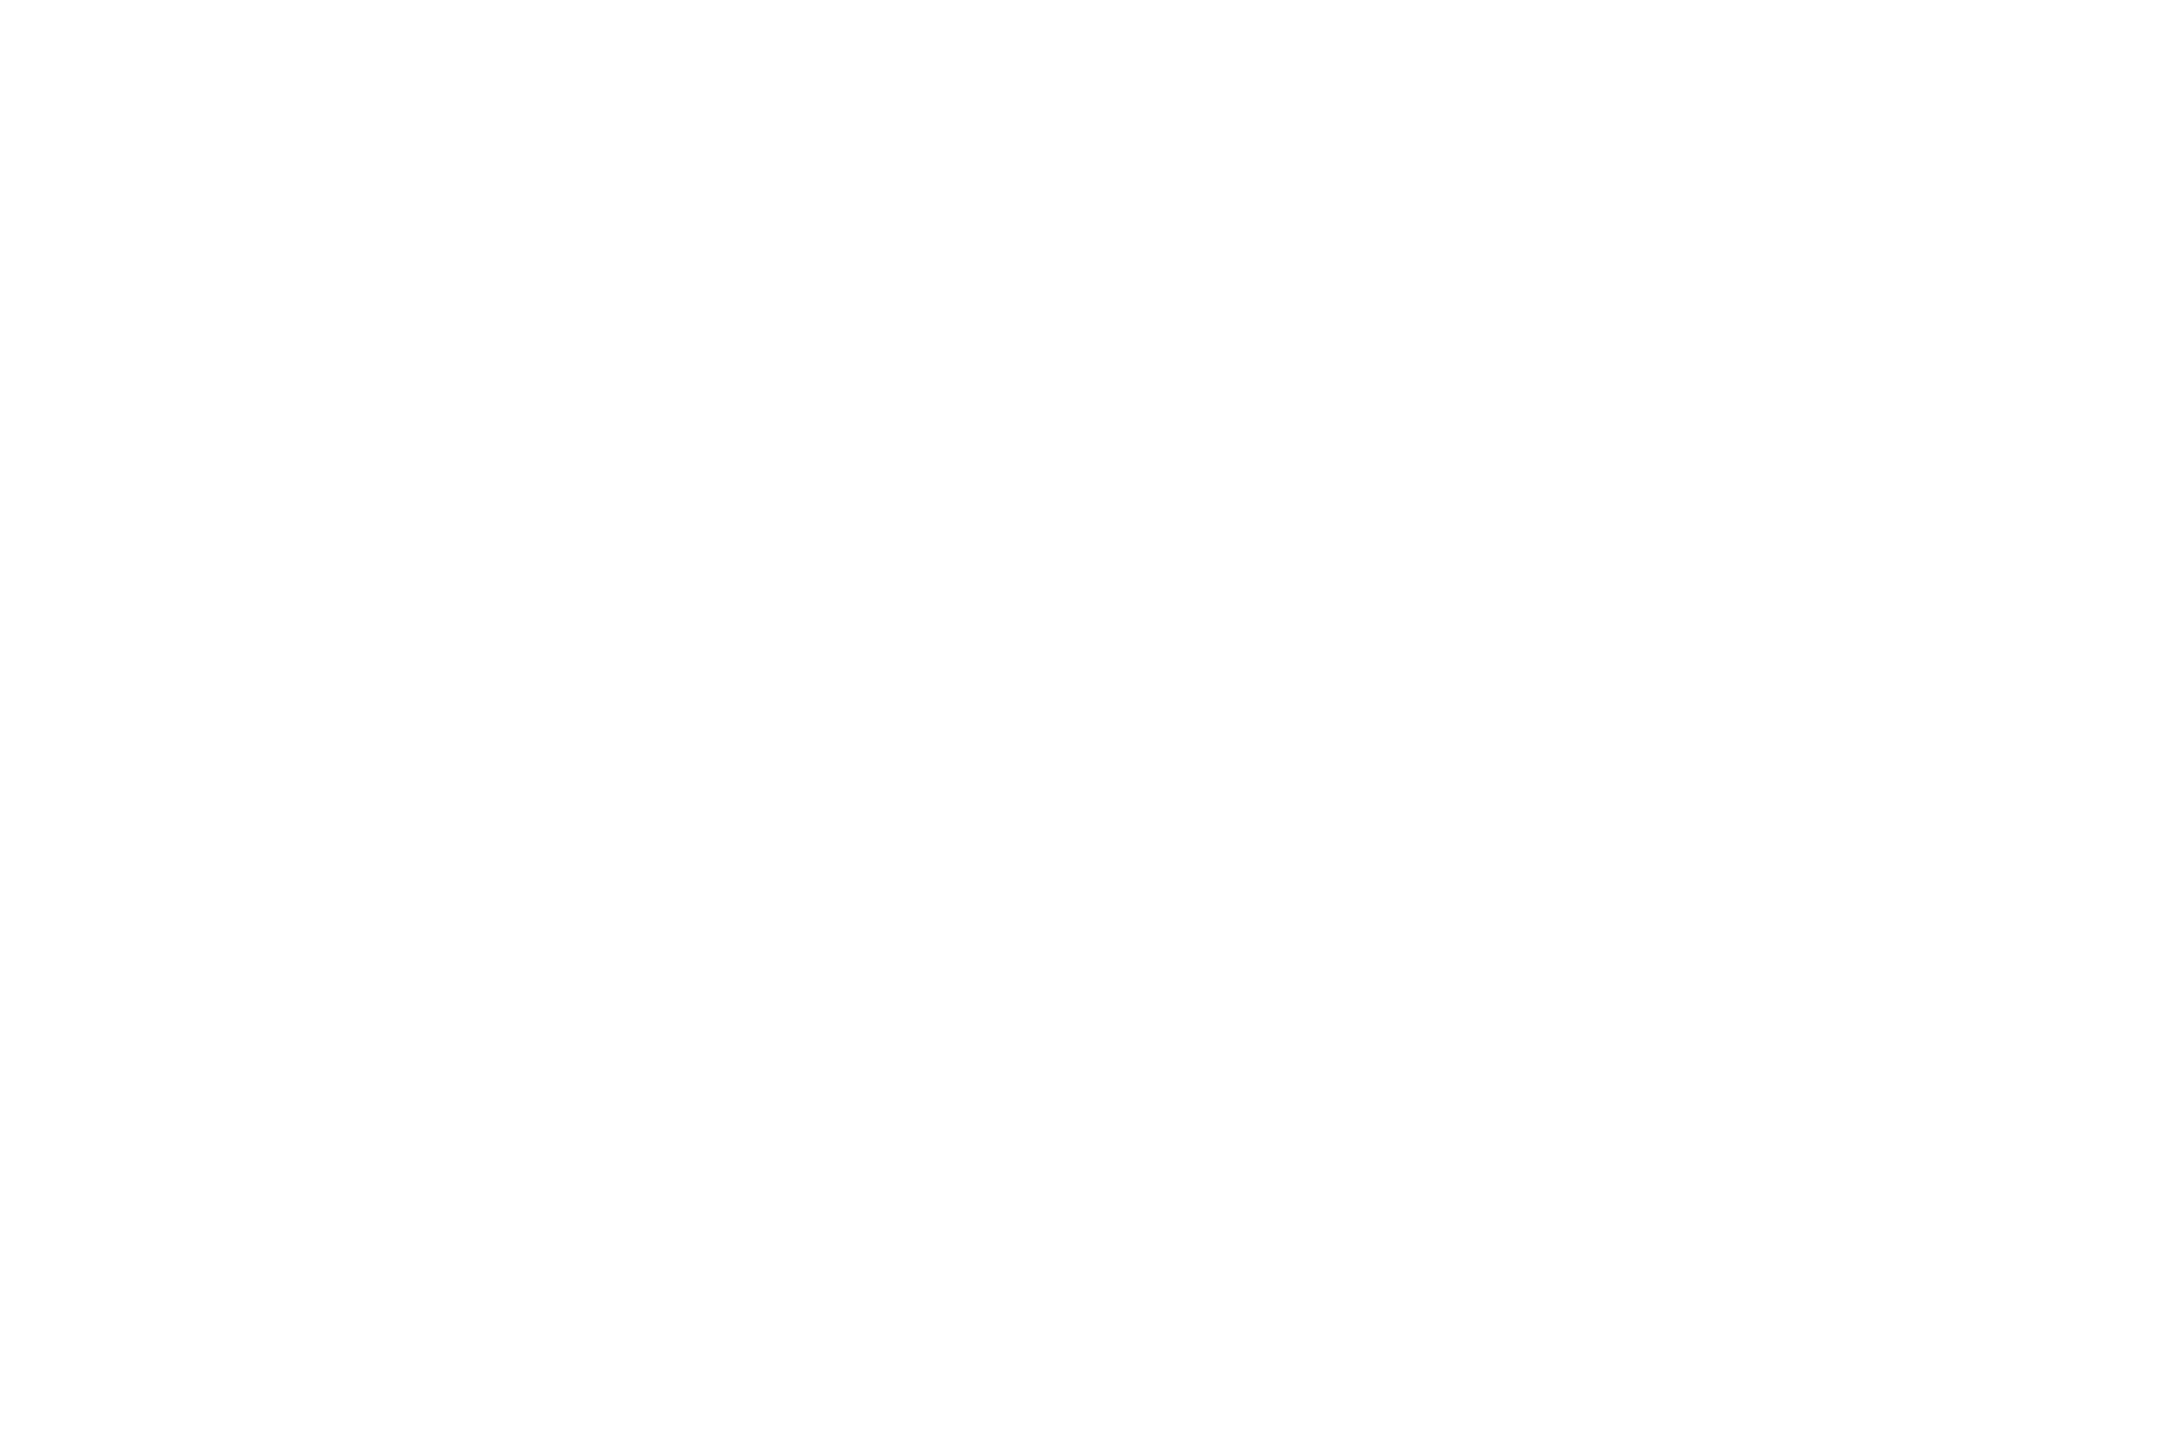

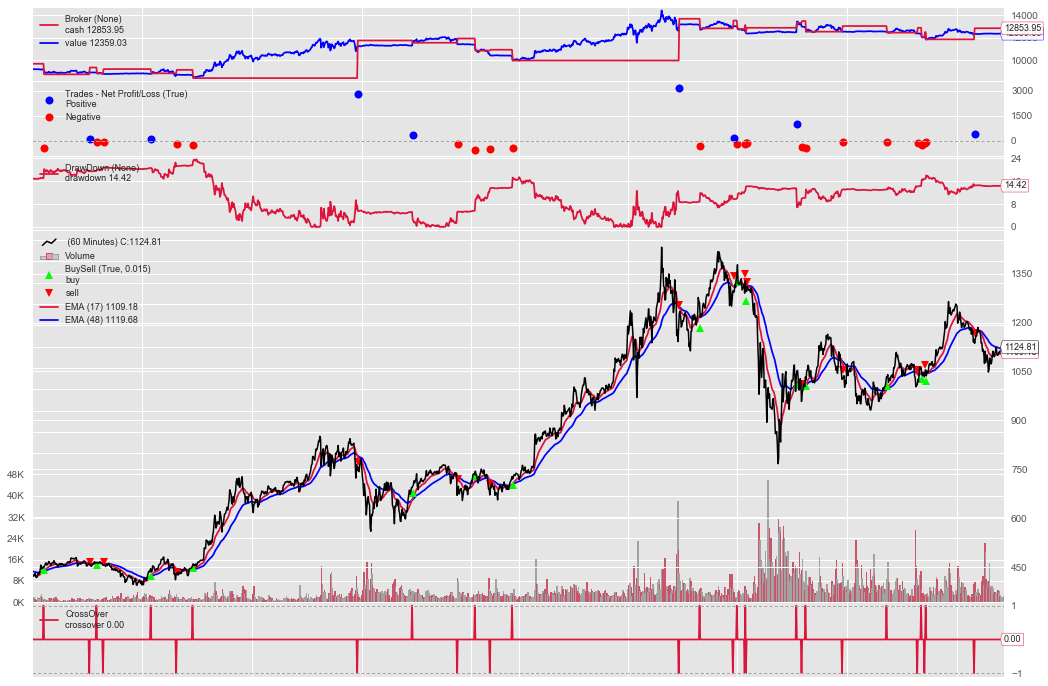

In [54]:
# EMA Crossover ETHER (17h and 48h)

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest

### Returns improved


# 2.6 Now we can check if the result could be improved with optimised parameters. 

### Short EMA (15-20), Long EMA (45-50)

In [93]:
# Parameter optimisation for Simple EMA Crossover

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', False),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))
    
    
#     UNCOMMENT TO OPTIMISE
    def stop(self):
        self.log('(Short EMA %2d), (Long EMA: %2d) Ending Value %.2f' %
                 (self.params.short_ema, self.params.long_ema, self.broker.getvalue()),
                 doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        short_ema=range(15, 21),
        long_ema=range(45, 51))
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Add a Percentage sizer - set to 5% of portfolio value
    # cerebro.addsizer(bt.sizers.PercentSizer, percents=5)
    # cerebro.addsizer(bt.sizers.FixedSize)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Run over everything
    thestrats = cerebro.run(maxcpus=2)  # OPTIMIZE
    thestrat = thestrats[0]


Starting Portfolio Value: 10000.00
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 46) Ending Value 22371.20
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 45) Ending Value 22092.45
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 47) Ending Value 21530.66
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 48) Ending Value 21299.75
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 49) Ending Value 20572.43
2019-08-20T10:59:59.998997, (Short EMA 15), (Long EMA: 50) Ending Value 21080.54
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 45) Ending Value 20075.06
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 46) Ending Value 20364.62
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 47) Ending Value 21826.97
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 48) Ending Value 21792.42
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 49) Ending Value 22431.36
2019-08-20T10:59:59.998997, (Short EMA 16), (Long EMA: 50) Ending Value 22

### So the best parameters were 20 and 50 which got us 27k instead of 22k

# 2.7 Backtest with Optimised parameters for ETH / USDT

Starting Portfolio Value: 10000.00
2017-08-20T21:59:59.999000, BUY CREATE , 298.13
2017-08-20T22:59:59.998997, BUY EXECUTED, Price: 298.13, Cost: 500.86, Comm 0.50
2017-08-20T22:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 500.86
2017-08-22T08:59:59.999004, CLOSE LONG , 299.82
2017-08-22T08:59:59.999004, SELL CREATE , 299.82
2017-08-22T09:59:59.999000, SELL EXECUTED, Price: 301.09, Cost: 500.86, Comm 0.53
2017-08-22T09:59:59.999000, SELL EXECUTED, Price: 301.09, Cost: -502.82, Comm 0.50
2017-08-22T09:59:59.999000, OPERATION PROFIT, GROSS 49.73, NET 48.69, Acc Balance: 10036.10
2017-08-22T09:59:59.999000, TRADE OPENED, SIZE: -1 , VAL: -502.82
2017-08-22T12:59:59.999000, CLOSE SHORT , 311.23
2017-08-22T12:59:59.999000, BUY CREATE , 311.23
2017-08-22T13:59:59.998997, BUY EXECUTED, Price: 306.66, Cost: -502.82, Comm 0.51
2017-08-22T13:59:59.998997, BUY EXECUTED, Price: 306.66, Cost: 493.72, Comm 0.49
2017-08-22T13:59:59.998997, OPERATION PROFIT, GROSS -93.02, NET -94.03, Acc Balance: 9960.3

2017-11-05T20:59:59.999004, CLOSE LONG , 294.63
2017-11-05T20:59:59.999004, SELL CREATE , 294.63
2017-11-05T21:59:59.999000, SELL EXECUTED, Price: 294.63, Cost: 472.48, Comm 0.49
2017-11-05T21:59:59.999000, SELL EXECUTED, Price: 294.63, Cost: -474.35, Comm 0.47
2017-11-05T21:59:59.999000, OPERATION PROFIT, GROSS -40.23, NET -41.19, Acc Balance: 9502.38
2017-11-05T21:59:59.999000, TRADE OPENED, SIZE: -1 , VAL: -474.35
2017-11-06T12:59:59.999000, CLOSE SHORT , 301.06
2017-11-06T12:59:59.999000, BUY CREATE , 301.06
2017-11-06T13:59:59.998997, BUY EXECUTED, Price: 301.08, Cost: -474.35, Comm 0.50
2017-11-06T13:59:59.998997, BUY EXECUTED, Price: 301.08, Cost: 475.71, Comm 0.48
2017-11-06T13:59:59.998997, OPERATION PROFIT, GROSS -103.84, NET -104.82, Acc Balance: 9370.23
2017-11-06T13:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 475.71
2017-11-07T14:59:59.999004, CLOSE LONG , 287.80
2017-11-07T14:59:59.999004, SELL CREATE , 287.80
2017-11-07T15:59:59.999000, SELL EXECUTED, Price: 287.80, Cost

2018-02-01T05:59:59.999004, CLOSE SHORT , 1159.13
2018-02-01T05:59:59.999004, BUY CREATE , 1159.13
2018-02-01T06:59:59.999000, BUY EXECUTED, Price: 1159.02, Cost: -494.71, Comm 0.53
2018-02-01T06:59:59.999000, BUY EXECUTED, Price: 1159.02, Cost: 498.38, Comm 0.50
2018-02-01T06:59:59.999000, OPERATION PROFIT, GROSS -36.72, NET -37.74, Acc Balance: 14843.18
2018-02-01T06:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 498.38
2018-02-01T09:59:59.999000, CLOSE LONG , 1101.74
2018-02-01T09:59:59.999000, SELL CREATE , 1101.74
2018-02-01T10:59:59.998997, SELL EXECUTED, Price: 1100.16, Cost: 498.38, Comm 0.47
2018-02-01T10:59:59.998997, SELL EXECUTED, Price: 1100.16, Cost: -495.07, Comm 0.50
2018-02-01T10:59:59.998997, OPERATION PROFIT, GROSS -253.10, NET -254.07, Acc Balance: 14653.71
2018-02-01T10:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -495.07
2018-02-07T10:59:59.998997, CLOSE SHORT , 828.35
2018-02-07T10:59:59.998997, BUY CREATE , 828.35
2018-02-07T11:59:59.999004, BUY EXECUTED, Price: 828

2018-04-07T10:59:59.998997, BUY EXECUTED, Price: 381.32, Cost: 499.53, Comm 0.50
2018-04-07T10:59:59.998997, OPERATION PROFIT, GROSS -96.21, NET -97.27, Acc Balance: 16581.05
2018-04-07T10:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 499.53
2018-04-16T19:59:59.998997, CLOSE LONG , 503.53
2018-04-16T19:59:59.998997, SELL CREATE , 503.53
2018-04-16T20:59:59.999004, SELL EXECUTED, Price: 503.55, Cost: 499.53, Comm 0.78
2018-04-16T20:59:59.999004, SELL EXECUTED, Price: 503.55, Cost: -498.51, Comm 0.50
2018-04-16T20:59:59.999004, OPERATION PROFIT, GROSS 1601.21, NET 1599.93, Acc Balance: 18178.74
2018-04-16T20:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -498.51
2018-04-17T09:59:59.999000, CLOSE SHORT , 518.05
2018-04-17T09:59:59.999000, BUY CREATE , 518.05
2018-04-17T10:59:59.998997, BUY EXECUTED, Price: 518.72, Cost: -498.51, Comm 0.53
2018-04-17T10:59:59.998997, BUY EXECUTED, Price: 518.72, Cost: 503.16, Comm 0.50
2018-04-17T10:59:59.998997, OPERATION PROFIT, GROSS -150.18, NET -151.21, Ac

2018-06-22T00:59:59.999000, CLOSE LONG , 524.70
2018-06-22T00:59:59.999000, SELL CREATE , 524.70
2018-06-22T01:59:59.998997, SELL EXECUTED, Price: 524.71, Cost: 501.99, Comm 0.56
2018-06-22T01:59:59.998997, SELL EXECUTED, Price: 524.71, Cost: -498.47, Comm 0.50
2018-06-22T01:59:59.998997, OPERATION PROFIT, GROSS 69.74, NET 68.68, Acc Balance: 19488.38
2018-06-22T01:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -498.47
2018-06-30T03:59:59.999000, CLOSE SHORT , 446.52
2018-06-30T03:59:59.999000, BUY CREATE , 446.52
2018-06-30T04:59:59.998997, BUY EXECUTED, Price: 446.78, Cost: -498.47, Comm 0.53
2018-06-30T04:59:59.998997, BUY EXECUTED, Price: 446.78, Cost: 500.39, Comm 0.50
2018-06-30T04:59:59.998997, OPERATION PROFIT, GROSS 740.34, NET 739.30, Acc Balance: 20259.73
2018-06-30T04:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 500.39
2018-07-05T20:59:59.999004, CLOSE LONG , 463.51
2018-07-05T20:59:59.999004, SELL CREATE , 463.51
2018-07-05T21:59:59.999000, SELL EXECUTED, Price: 463.95, Cost: 

2018-09-17T16:59:59.998997, CLOSE LONG , 205.25
2018-09-17T16:59:59.998997, SELL CREATE , 205.25
2018-09-17T17:59:59.999004, SELL EXECUTED, Price: 205.15, Cost: 499.28, Comm 0.60
2018-09-17T17:59:59.999004, SELL EXECUTED, Price: 205.15, Cost: -500.57, Comm 0.50
2018-09-17T17:59:59.999004, OPERATION PROFIT, GROSS 423.19, NET 422.10, Acc Balance: 22914.30
2018-09-17T17:59:59.999004, TRADE OPENED, SIZE: -2 , VAL: -500.57
2018-09-19T04:59:59.998997, CLOSE SHORT , 211.17
2018-09-19T04:59:59.998997, BUY CREATE , 211.17
2018-09-19T05:59:59.999004, BUY EXECUTED, Price: 211.13, Cost: -500.57, Comm 0.54
2018-09-19T05:59:59.999004, BUY EXECUTED, Price: 211.13, Cost: 500.38, Comm 0.50
2018-09-19T05:59:59.999004, OPERATION PROFIT, GROSS -145.91, NET -146.96, Acc Balance: 22781.62
2018-09-19T05:59:59.999004, TRADE OPENED, SIZE:  2 , VAL: 500.38
2018-09-19T18:59:59.999000, CLOSE LONG , 201.14
2018-09-19T18:59:59.999000, SELL CREATE , 201.14
2018-09-19T19:59:59.998997, SELL EXECUTED, Price: 200.45, Co

2018-10-29T01:59:59.998997, CLOSE SHORT , 205.15
2018-10-29T01:59:59.998997, BUY CREATE , 205.15
2018-10-29T02:59:59.999004, BUY EXECUTED, Price: 205.13, Cost: -500.46, Comm 0.53
2018-10-29T02:59:59.999004, BUY EXECUTED, Price: 205.13, Cost: 500.52, Comm 0.50
2018-10-29T02:59:59.999004, OPERATION PROFIT, GROSS -21.07, NET -22.10, Acc Balance: 21735.44
2018-10-29T02:59:59.999004, TRADE OPENED, SIZE:  2 , VAL: 500.52
2018-10-29T12:59:59.999000, CLOSE LONG , 197.55
2018-10-29T12:59:59.999000, SELL CREATE , 197.55
2018-10-29T13:59:59.998997, SELL EXECUTED, Price: 197.55, Cost: 500.52, Comm 0.48
2018-10-29T13:59:59.998997, SELL EXECUTED, Price: 197.55, Cost: -499.80, Comm 0.50
2018-10-29T13:59:59.998997, OPERATION PROFIT, GROSS -184.95, NET -185.93, Acc Balance: 21553.37
2018-10-29T13:59:59.998997, TRADE OPENED, SIZE: -2 , VAL: -499.80
2018-11-01T07:59:59.998997, CLOSE SHORT , 199.17
2018-11-01T07:59:59.998997, BUY CREATE , 199.17
2018-11-01T08:59:59.999004, BUY EXECUTED, Price: 199.17, Cos

2019-01-19T11:59:59.999004, CLOSE SHORT , 123.49
2019-01-19T11:59:59.999004, BUY CREATE , 123.49
2019-01-19T12:59:59.999000, BUY EXECUTED, Price: 123.50, Cost: -499.51, Comm 0.56
2019-01-19T12:59:59.999000, BUY EXECUTED, Price: 123.50, Cost: 500.17, Comm 0.50
2019-01-19T12:59:59.999000, OPERATION PROFIT, GROSS -191.94, NET -193.00, Acc Balance: 26133.12
2019-01-19T12:59:59.999000, TRADE OPENED, SIZE:  4 , VAL: 500.17
2019-01-20T13:59:59.998997, CLOSE LONG , 117.93
2019-01-20T13:59:59.998997, SELL CREATE , 117.93
2019-01-20T14:59:59.999004, SELL EXECUTED, Price: 117.93, Cost: 500.17, Comm 0.49
2019-01-20T14:59:59.999004, SELL EXECUTED, Price: 117.93, Cost: -500.02, Comm 0.50
2019-01-20T14:59:59.999004, OPERATION PROFIT, GROSS -225.58, NET -226.58, Acc Balance: 25906.40
2019-01-20T14:59:59.999004, TRADE OPENED, SIZE: -4 , VAL: -500.02
2019-01-23T00:59:59.999000, CLOSE SHORT , 117.97
2019-01-23T00:59:59.999000, BUY CREATE , 117.97
2019-01-23T01:59:59.998997, BUY EXECUTED, Price: 118.00, C

2019-04-04T18:59:59.999000, CLOSE LONG , 155.06
2019-04-04T18:59:59.999000, SELL CREATE , 155.06
2019-04-04T19:59:59.998997, SELL EXECUTED, Price: 155.05, Cost: 499.52, Comm 0.57
2019-04-04T19:59:59.998997, SELL EXECUTED, Price: 155.05, Cost: -499.26, Comm 0.50
2019-04-04T19:59:59.998997, OPERATION PROFIT, GROSS 462.53, NET 461.46, Acc Balance: 27080.87
2019-04-04T19:59:59.998997, TRADE OPENED, SIZE: -3 , VAL: -499.26
2019-04-05T07:59:59.998997, CLOSE SHORT , 162.91
2019-04-05T07:59:59.998997, BUY CREATE , 162.91
2019-04-05T08:59:59.999004, BUY EXECUTED, Price: 162.97, Cost: -499.26, Comm 0.54
2019-04-05T08:59:59.999004, BUY EXECUTED, Price: 162.97, Cost: 500.32, Comm 0.50
2019-04-05T08:59:59.999004, OPERATION PROFIT, GROSS -255.02, NET -256.06, Acc Balance: 26855.21
2019-04-05T08:59:59.999004, TRADE OPENED, SIZE:  3 , VAL: 500.32
2019-04-11T03:59:59.999000, CLOSE LONG , 168.88
2019-04-11T03:59:59.999000, SELL CREATE , 168.88
2019-04-11T04:59:59.998997, SELL EXECUTED, Price: 168.82, Co

2019-05-17T16:59:59.998997, CLOSE LONG , 230.46
2019-05-17T16:59:59.998997, SELL CREATE , 230.46
2019-05-17T17:59:59.999004, SELL EXECUTED, Price: 230.40, Cost: 500.57, Comm 0.75
2019-05-17T17:59:59.999004, SELL EXECUTED, Price: 230.40, Cost: -499.97, Comm 0.50
2019-05-17T17:59:59.999004, OPERATION PROFIT, GROSS 1560.66, NET 1559.41, Acc Balance: 27799.76
2019-05-17T17:59:59.999004, TRADE OPENED, SIZE: -2 , VAL: -499.97
2019-05-19T03:59:59.999000, CLOSE SHORT , 252.75
2019-05-19T03:59:59.999000, BUY CREATE , 252.75
2019-05-19T04:59:59.998997, BUY EXECUTED, Price: 252.78, Cost: -499.97, Comm 0.58
2019-05-19T04:59:59.998997, BUY EXECUTED, Price: 252.78, Cost: 500.50, Comm 0.50
2019-05-19T04:59:59.998997, OPERATION PROFIT, GROSS -485.65, NET -486.72, Acc Balance: 27313.17
2019-05-19T04:59:59.998997, TRADE OPENED, SIZE:  1 , VAL: 500.50
2019-05-22T21:59:59.999000, CLOSE LONG , 243.01
2019-05-22T21:59:59.999000, SELL CREATE , 243.01
2019-05-22T22:59:59.998997, SELL EXECUTED, Price: 243.01, 

2019-08-07T01:59:59.998997, CLOSE LONG , 225.84
2019-08-07T01:59:59.998997, SELL CREATE , 225.84
2019-08-07T02:59:59.999004, SELL EXECUTED, Price: 225.89, Cost: 499.02, Comm 0.63
2019-08-07T02:59:59.999004, SELL EXECUTED, Price: 225.89, Cost: -499.22, Comm 0.50
2019-08-07T02:59:59.999004, OPERATION PROFIT, GROSS 318.19, NET 317.06, Acc Balance: 26524.22
2019-08-07T02:59:59.999004, TRADE OPENED, SIZE: -2 , VAL: -499.22
2019-08-11T19:59:59.998997, CLOSE SHORT , 215.49
2019-08-11T19:59:59.998997, BUY CREATE , 215.49
2019-08-11T20:59:59.999004, BUY EXECUTED, Price: 215.49, Cost: -499.22, Comm 0.53
2019-08-11T20:59:59.999004, BUY EXECUTED, Price: 215.49, Cost: 499.94, Comm 0.50
2019-08-11T20:59:59.999004, OPERATION PROFIT, GROSS 229.84, NET 228.81, Acc Balance: 26758.45
2019-08-11T20:59:59.999004, TRADE OPENED, SIZE:  2 , VAL: 499.94
2019-08-12T22:59:59.998997, CLOSE LONG , 211.51
2019-08-12T22:59:59.998997, SELL CREATE , 211.51
2019-08-12T23:59:59.999004, SELL EXECUTED, Price: 211.50, Cost

<IPython.core.display.Javascript object>


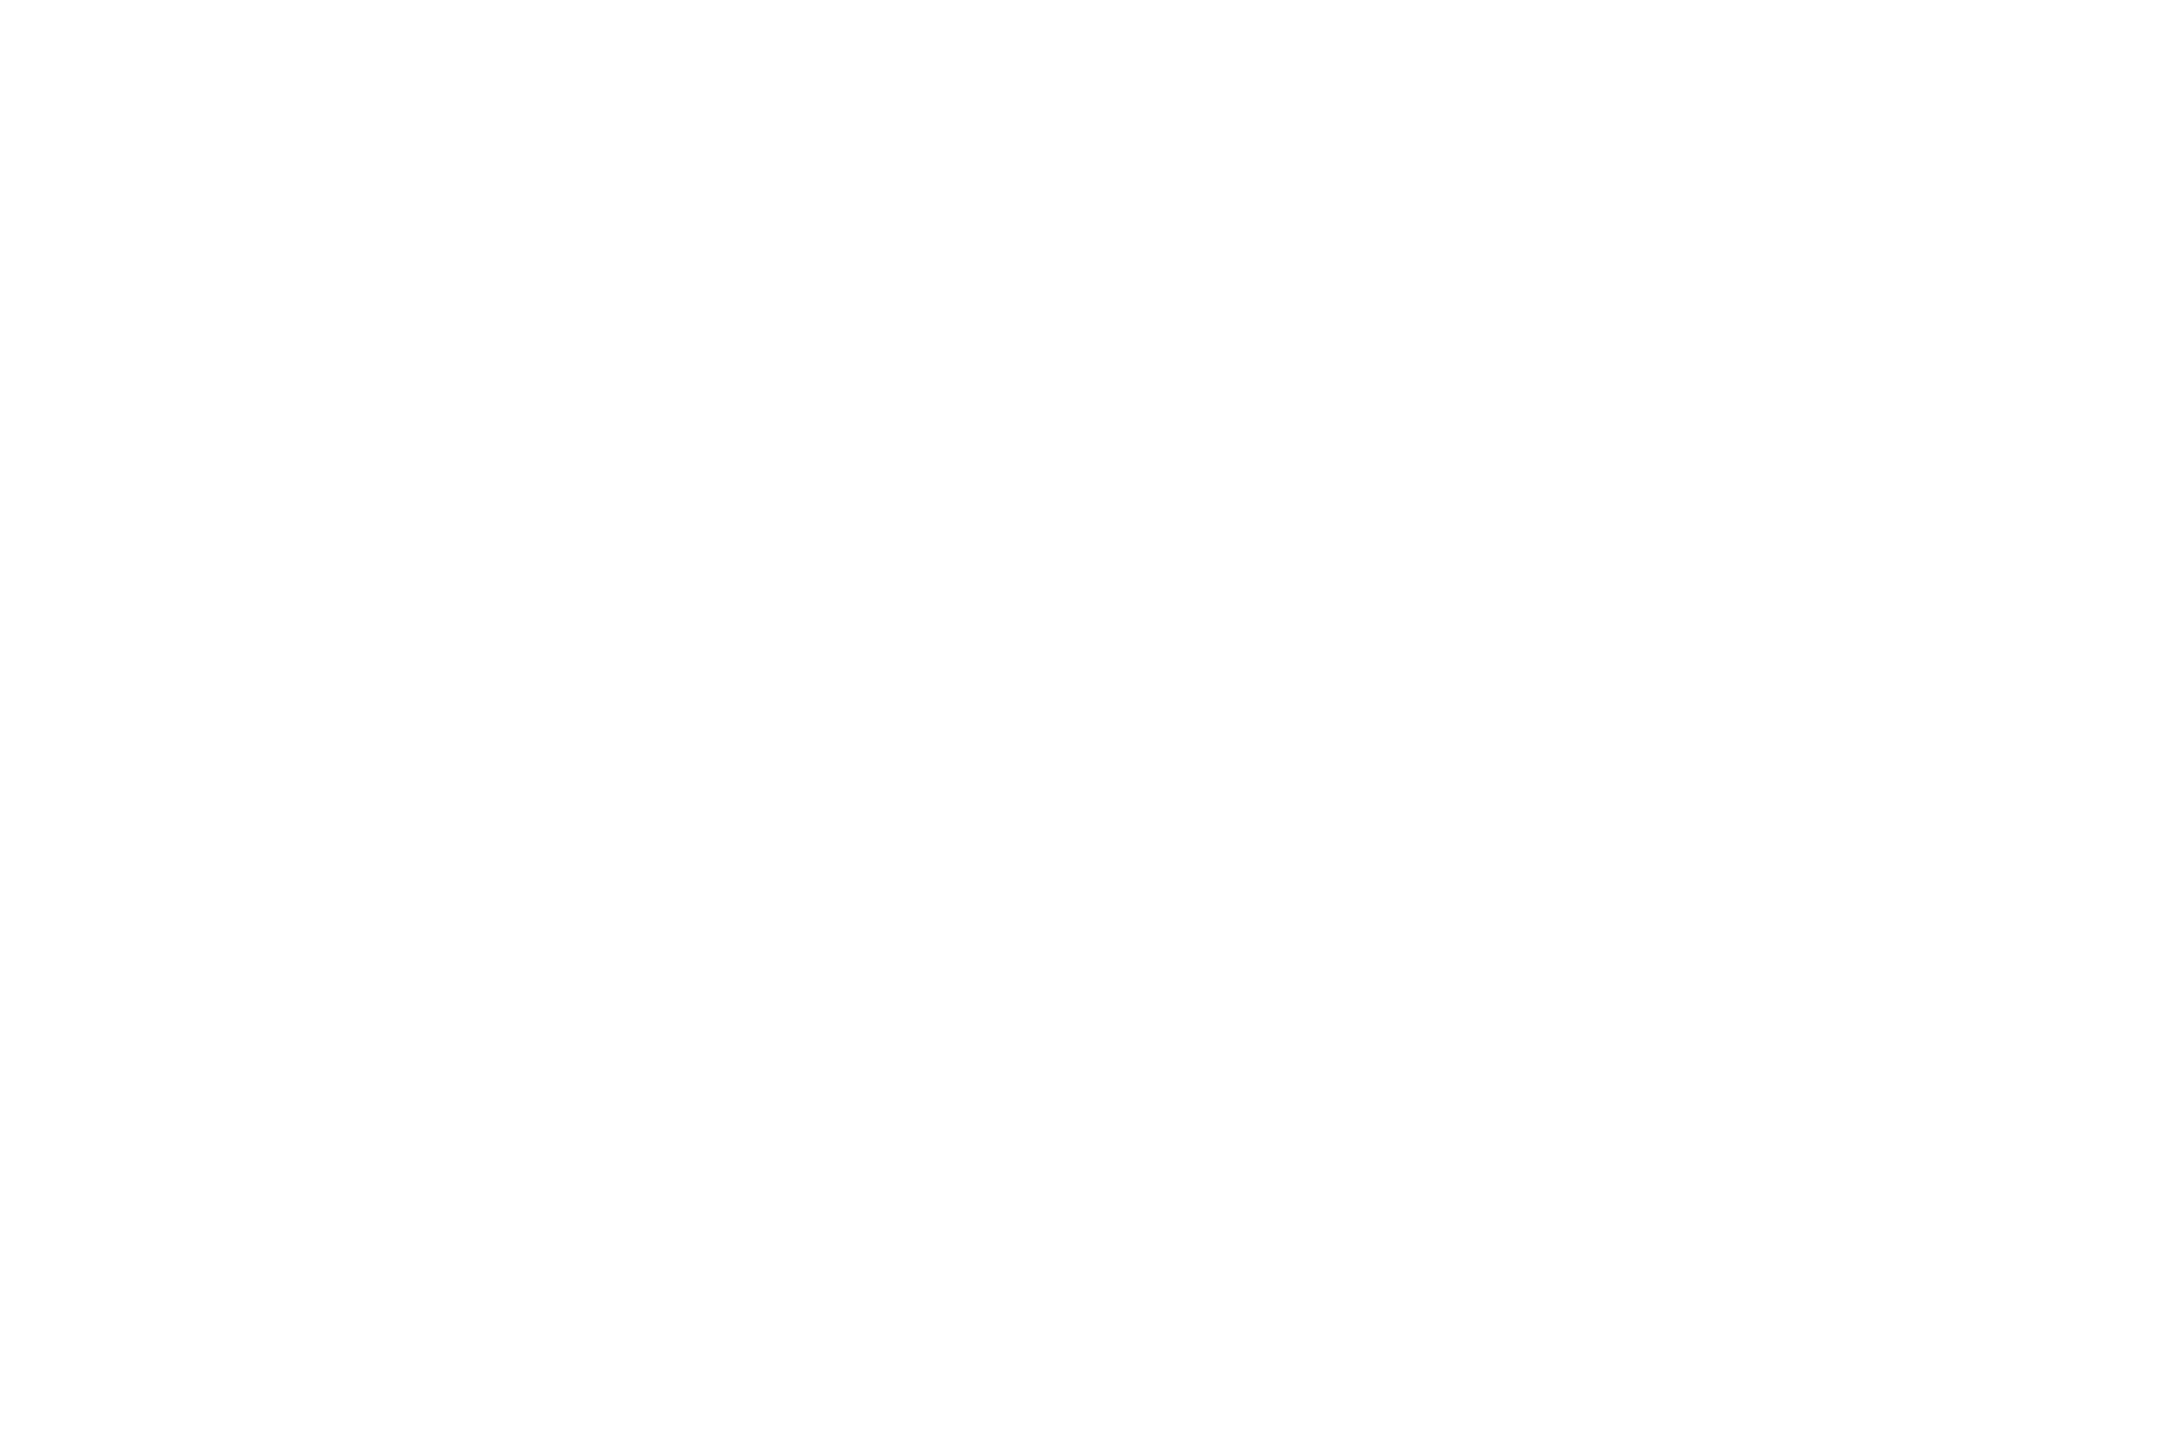

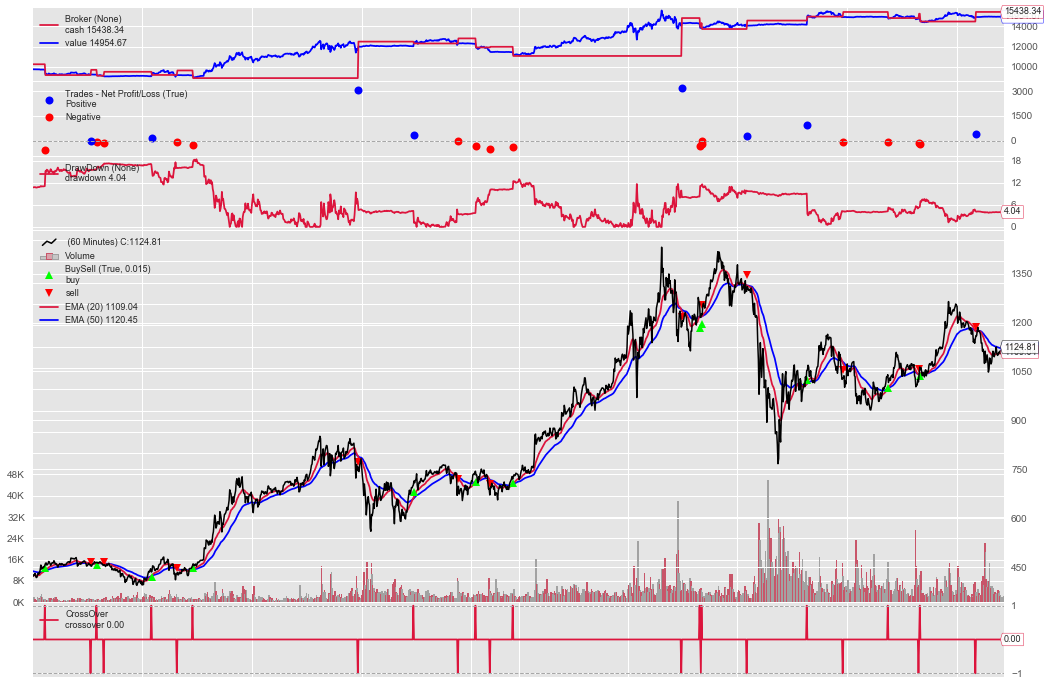

In [57]:
# Backtest with optimised parameters on ETH/USD

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 20),
        ('long_ema', 50),
        ('mult', 10),
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=eth_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest



#### So with these parameters Portfolio value increased, Sharpe and CAGR increased. Less trades were made and strike rate increased while DrawDown decreased

# 3 Bitcoin now

# 3.1 Download and organise data from Binance (BTC / USDT) 1 hour candles

In [58]:
# download data (might take a minute)
# BTC/USDT pair at 1 hour granularity
btc_usdt1h_raw = pd.DataFrame(client.get_historical_klines("BTCUSDT", 
                                                           Client.KLINE_INTERVAL_1HOUR, 
                                                           '1 Jan 2017'))

In [59]:
# organise btc/usdt data
btc_usdt1h = organise_binance_klines(btc_usdt1h_raw, save_csv=True, csv_name='btc_usdt1h')

# describe downloaded data
btc_usdt1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17517 entries, 2017-08-17 04:59:59.999000 to 2019-08-20 20:59:59.999000
Data columns (total 13 columns):
open_time_unix                  17517 non-null int64
open                            17517 non-null float64
high                            17517 non-null float64
low                             17517 non-null float64
close                           17517 non-null float64
volume                          17517 non-null float64
close_time_unix                 17517 non-null int64
quote_asset_volume              17517 non-null float64
number_of_trades                17517 non-null int64
taker_buy_base_asset_volume     17517 non-null float64
taker_buy_quote_asset_volume    17517 non-null float64
ignore                          17517 non-null object
candle-start                    17517 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 1.9+ MB


In [60]:
btc_usdt1h.head()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,candle-start
candle-end,,,,,,,,,,,,,
2017-08-17 04:59:59.999,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,1502945999999,202366.138393,171,35.160503,150952.477943,7887.63551305,2017-08-17 04:00:00
2017-08-17 05:59:59.999,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,1502949599999,100304.823567,102,21.448071,92608.279728,8039.26240152,2017-08-17 05:00:00
2017-08-17 06:59:59.999,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,1502953199999,31282.312670,36,4.802861,20795.317224,8041.76049845,2017-08-17 06:00:00
2017-08-17 07:59:59.999,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,1502956799999,19241.058300,25,2.602292,11291.347015,8048.12788573,2017-08-17 07:00:00
2017-08-17 08:59:59.999,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,1502960399999,4239.503586,28,0.814655,3552.746817,8018.03650010,2017-08-17 08:00:00


In [61]:
btc_usdt1h.describe()

,open_time_unix,open,high,low,close,volume,close_time_unix,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,1.751700e+04,17517.000000,17517.000000,17517.000000,17517.000000,17517.000000,1.751700e+04,1.751700e+04,17517.000000,17517.000000,1.751700e+04
mean,1.534647e+12,7269.047155,7321.841279,7211.810547,7269.389006,1341.827178,1.534651e+12,1.005846e+07,9766.132899,690.738943,5.159045e+06
std,1.829954e+10,3039.299752,3081.342359,2991.175847,3039.284175,1361.442390,1.829954e+10,1.190092e+07,9267.547669,681.701614,5.931332e+06
min,1.502942e+12,2870.900000,2950.000000,2817.000000,2919.000000,0.000000,1.502946e+12,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.518851e+12,4640.960000,4683.770000,4608.010000,4640.330000,554.157735,1.518854e+12,3.180093e+06,4754.000000,282.384702,1.640805e+06
50%,1.534680e+12,6657.730000,6685.660000,6628.920000,6658.980000,1046.353288,1.534684e+12,7.255247e+06,7582.000000,551.471145,3.790402e+06
75%,1.550480e+12,8852.120000,8920.000000,8779.000000,8855.110000,1696.286009,1.550484e+12,1.257716e+07,12330.000000,883.392700,6.587391e+06
max,1.566331e+12,19709.500000,19798.680000,19552.000000,19709.500000,21248.059869,1.566335e+12,2.122868e+08,135909.000000,11409.932517,1.390818e+08


# 3.2 Visualise BTC price data

<IPython.core.display.Javascript object>


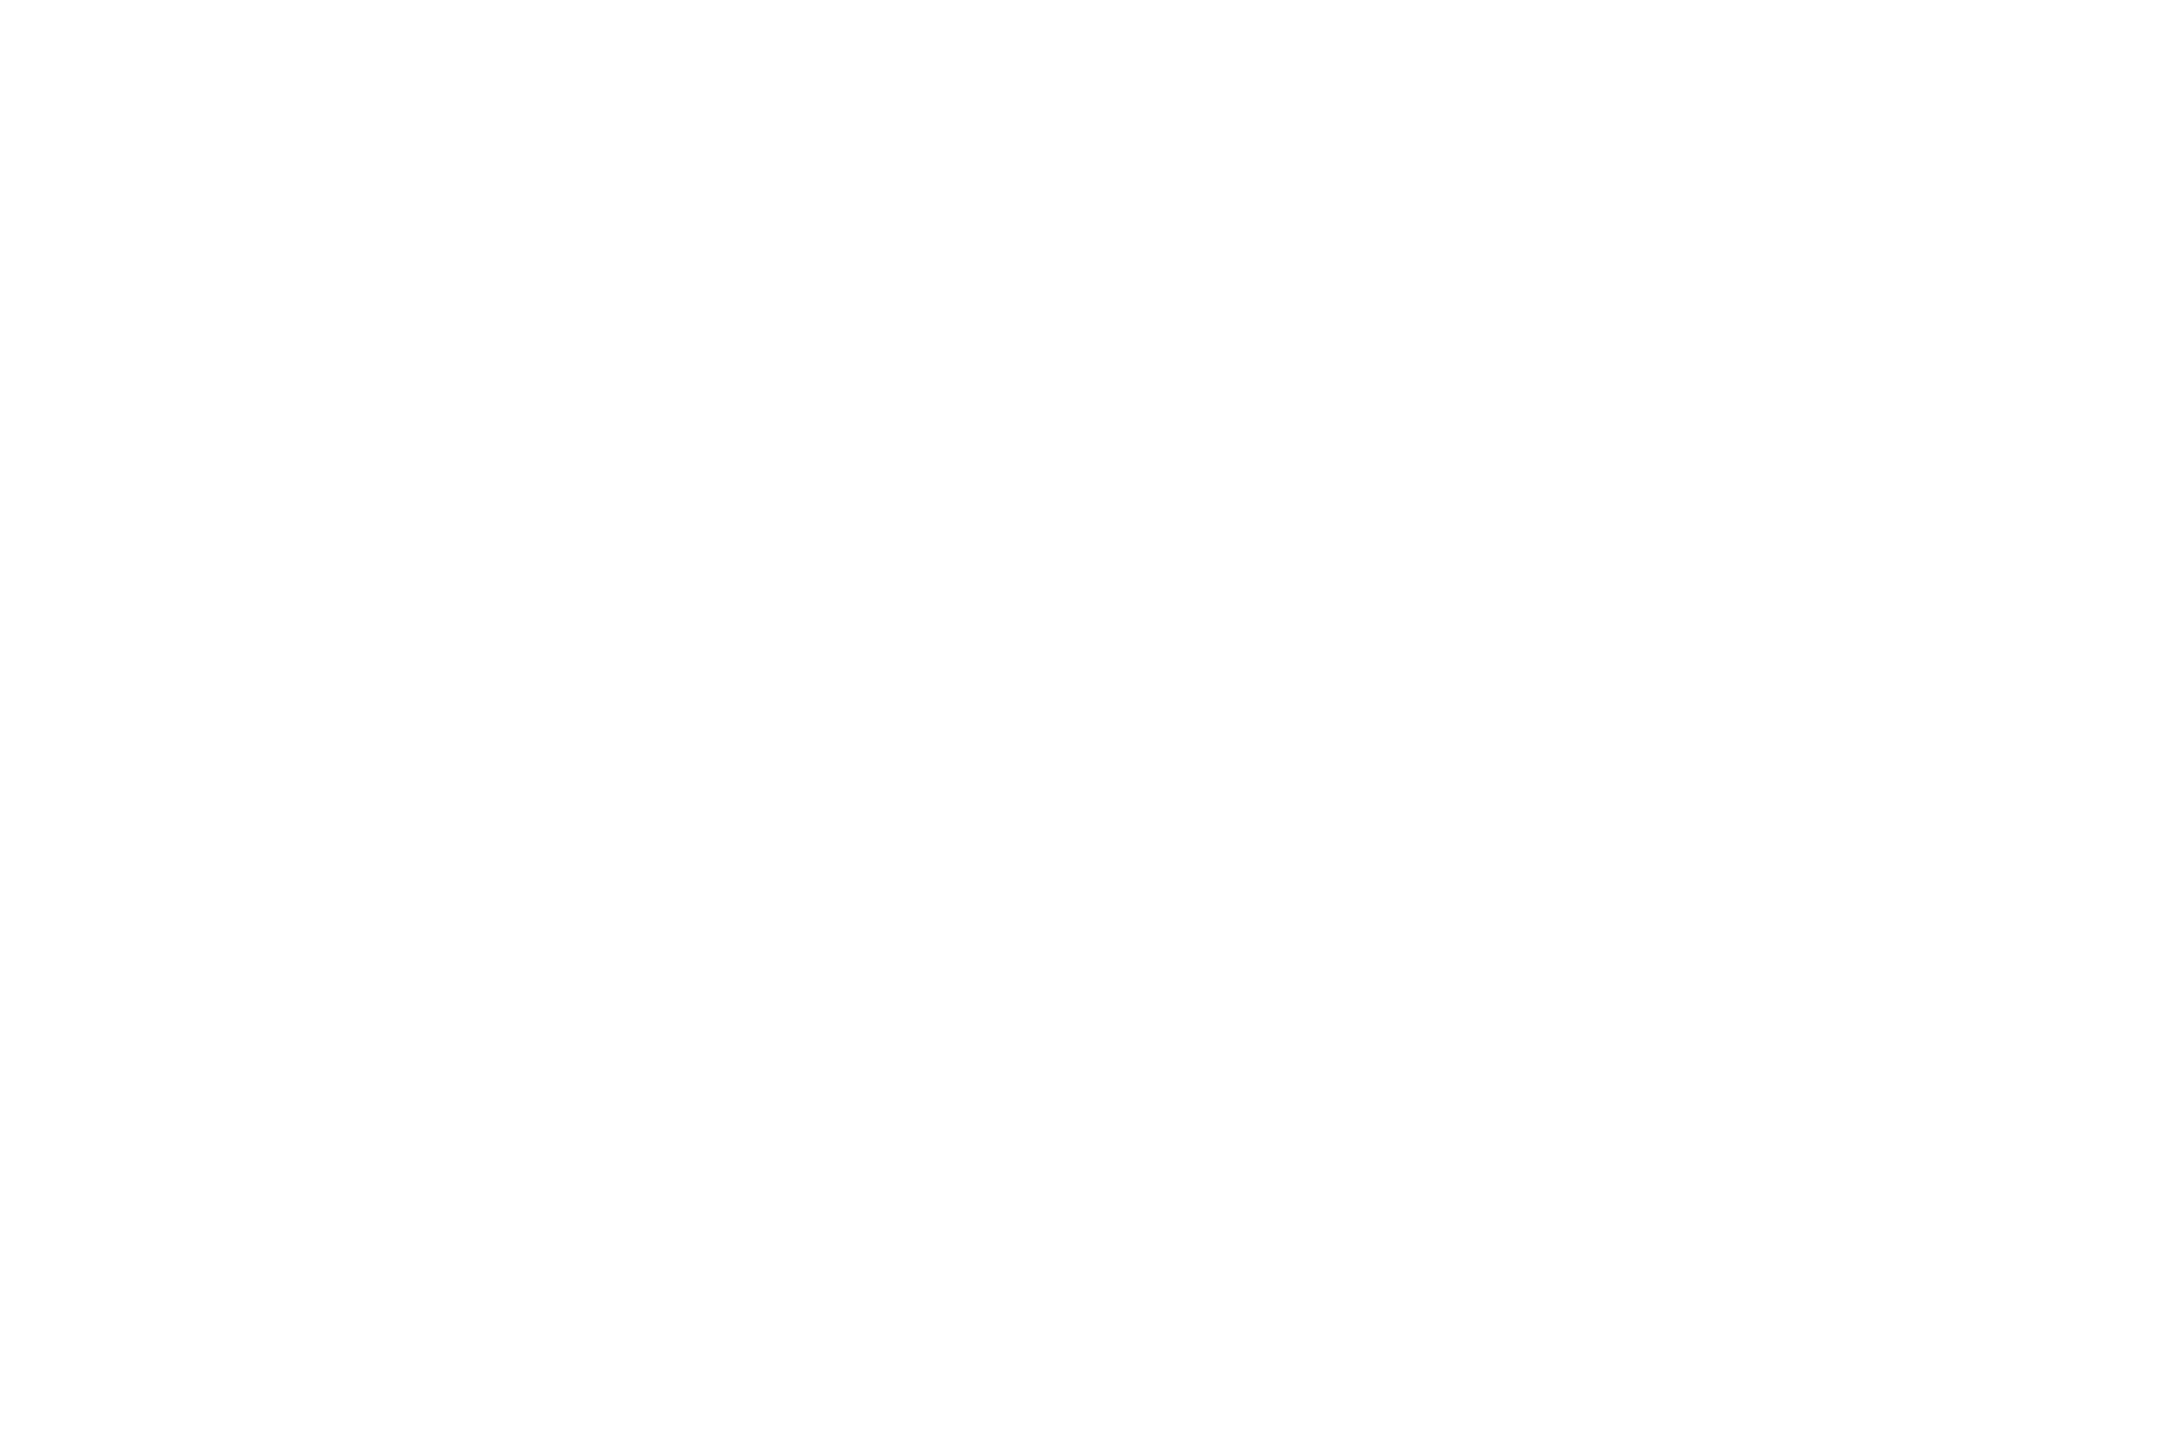

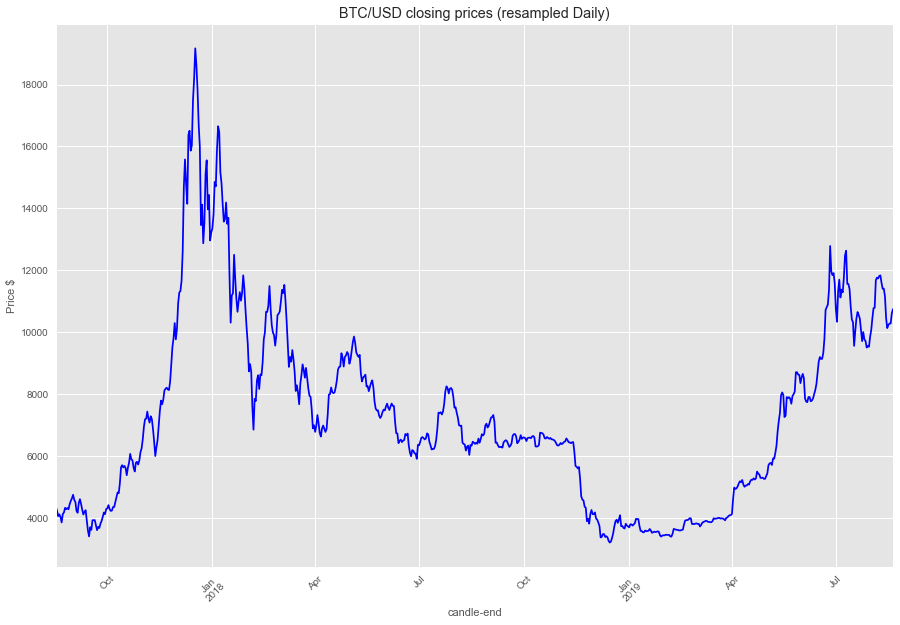

In [94]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot()
ax1.set_xlabel(xlabel='Time', fontsize=11)
ax1.set_ylabel(ylabel='Price $', fontsize=11)

# data is in hourly resolution, so resampling it in daily format to smooth graph
btc_usdt1h['close'].resample('D').mean().plot(ax=ax1, color='blue')

plt.title('BTC/USD closing prices (resampled Daily)')

plt.xticks(rotation=45)

plt.show()

# 3.3 Backtest: EMA and Price Crossover strategy on BTC / USDT 1h

Starting Portfolio Value: 10000.00
2017-08-23T01:59:59.998997, BUY CREATE , 4100.00
2017-08-23T02:59:59.999004, BUY EXECUTED, Price: 4101.53, Cost: 492.18, Comm 0.49
2017-08-23T02:59:59.999004, Trade id: 24146
2017-08-26T02:59:59.999004, CLOSE LONG , 4266.04 , Wait for Short
2017-08-26T03:59:59.999000, SELL EXECUTED, Price: 4245.01, Cost: 492.18, Comm 0.55
2017-08-26T03:59:59.999000, OPERATION PROFIT, GROSS 172.18, NET 171.13, Acc Balance: 10171.13
2017-08-28T04:59:59.998997, SELL CREATE , 4227.00
2017-08-28T05:59:59.999004, SELL EXECUTED, Price: 4251.92, Cost: -510.23, Comm 0.51
2017-08-28T05:59:59.999004, Trade id: 24147
2017-08-28T10:59:59.998997, CLOSE SHORT , 4290.77 , Wait for Long
2017-08-28T11:59:59.999004, BUY EXECUTED, Price: 4290.77, Cost: -510.23, Comm 0.51
2017-08-28T11:59:59.999004, OPERATION PROFIT, GROSS -46.62, NET -47.65, Acc Balance: 10123.49
2017-08-28T19:59:59.998997, BUY CREATE , 4321.65
2017-08-28T20:59:59.999004, BUY EXECUTED, Price: 4321.65, Cost: 518.60, Comm 

2017-11-04T01:59:59.998997, CLOSE LONG , 6980.06 , Wait for Short
2017-11-04T02:59:59.999004, SELL EXECUTED, Price: 7028.98, Cost: 520.65, Comm 0.72
2017-11-04T02:59:59.999004, OPERATION PROFIT, GROSS 1119.59, NET 1118.35, Acc Balance: 11721.61
2017-11-06T15:59:59.999000, SELL CREATE , 7232.03
2017-11-06T16:59:59.998997, SELL EXECUTED, Price: 7235.02, Cost: -506.45, Comm 0.51
2017-11-06T16:59:59.998997, Trade id: 24175
2017-11-08T01:59:59.998997, CLOSE SHORT , 7275.00 , Wait for Long
2017-11-08T02:59:59.999004, BUY EXECUTED, Price: 7274.99, Cost: -506.45, Comm 0.54
2017-11-08T02:59:59.999004, OPERATION PROFIT, GROSS -27.98, NET -29.02, Acc Balance: 11692.59
2017-11-08T05:59:59.999004, BUY CREATE , 7357.97
2017-11-08T06:59:59.999000, BUY EXECUTED, Price: 7350.00, Cost: 514.50, Comm 0.51
2017-11-08T06:59:59.999000, Trade id: 24176
2017-11-08T18:59:59.999000, CLOSE LONG , 7070.00 , Wait for Short
2017-11-08T19:59:59.998997, SELL EXECUTED, Price: 7070.00, Cost: 514.50, Comm 0.49
2017-11-08

2018-01-21T15:59:59.999000, SELL CREATE , 11412.00
2018-01-21T16:59:59.998997, SELL EXECUTED, Price: 11420.99, Cost: -456.84, Comm 0.46
2018-01-21T16:59:59.998997, Trade id: 24203
2018-01-22T07:59:59.998997, CLOSE SHORT , 11743.97 , Wait for Long
2018-01-22T08:59:59.999004, BUY EXECUTED, Price: 11745.00, Cost: -456.84, Comm 0.48
2018-01-22T08:59:59.999004, OPERATION PROFIT, GROSS -129.60, NET -130.54, Acc Balance: 9647.04
2018-01-24T12:59:59.999000, BUY CREATE , 11316.38
2018-01-24T13:59:59.998997, BUY EXECUTED, Price: 11318.52, Cost: 452.74, Comm 0.45
2018-01-24T13:59:59.998997, Trade id: 24204
2018-01-25T12:59:59.999000, CLOSE LONG , 11065.00 , Wait for Short
2018-01-25T13:59:59.998997, SELL EXECUTED, Price: 11065.00, Cost: 452.74, Comm 0.46
2018-01-25T13:59:59.998997, OPERATION PROFIT, GROSS -101.41, NET -102.32, Acc Balance: 9544.72
2018-01-26T09:59:59.999000, SELL CREATE , 10490.00
2018-01-26T10:59:59.998997, SELL EXECUTED, Price: 10490.00, Cost: -524.50, Comm 0.52
2018-01-26T10:5

2018-04-27T01:59:59.998997, BUY CREATE , 9249.97
2018-04-27T02:59:59.999004, BUY EXECUTED, Price: 9240.00, Cost: 462.00, Comm 0.46
2018-04-27T02:59:59.999004, Trade id: 24234
2018-04-27T19:59:59.998997, CLOSE LONG , 9089.00 , Wait for Short
2018-04-27T20:59:59.999004, SELL EXECUTED, Price: 9089.12, Cost: 462.00, Comm 0.45
2018-04-27T20:59:59.999004, OPERATION PROFIT, GROSS -75.44, NET -76.36, Acc Balance: 9839.13
2018-04-28T02:59:59.999004, SELL CREATE , 9055.78
2018-04-28T03:59:59.999000, SELL EXECUTED, Price: 9053.47, Cost: -452.67, Comm 0.45
2018-04-28T03:59:59.999000, Trade id: 24235
2018-04-28T03:59:59.999000, CLOSE SHORT , 9155.00 , Wait for Long
2018-04-28T04:59:59.998997, BUY EXECUTED, Price: 9155.01, Cost: -452.67, Comm 0.46
2018-04-28T04:59:59.998997, OPERATION PROFIT, GROSS -50.77, NET -51.68, Acc Balance: 9787.45
2018-04-30T18:59:59.999000, BUY CREATE , 9350.00
2018-04-30T19:59:59.998997, BUY EXECUTED, Price: 9351.00, Cost: 467.55, Comm 0.47
2018-04-30T19:59:59.998997, Trad

2018-07-09T17:59:59.999004, CLOSE LONG , 6695.01 , Wait for Short
2018-07-09T18:59:59.999000, SELL EXECUTED, Price: 6695.99, Cost: 472.74, Comm 0.48
2018-07-09T18:59:59.999000, OPERATION PROFIT, GROSS -40.24, NET -41.20, Acc Balance: 9872.64
2018-07-10T02:59:59.999004, SELL CREATE , 6623.06
2018-07-10T03:59:59.999000, SELL EXECUTED, Price: 6626.51, Cost: -463.86, Comm 0.46
2018-07-10T03:59:59.999000, Trade id: 24269
2018-07-13T12:59:59.999000, CLOSE SHORT , 6277.48 , Wait for Long
2018-07-13T13:59:59.998997, BUY EXECUTED, Price: 6274.20, Cost: -463.86, Comm 0.48
2018-07-13T13:59:59.998997, OPERATION PROFIT, GROSS 246.62, NET 245.68, Acc Balance: 10118.32
2018-07-14T21:59:59.999000, BUY CREATE , 6264.00
2018-07-14T22:59:59.998997, BUY EXECUTED, Price: 6263.87, Cost: 501.11, Comm 0.50
2018-07-14T22:59:59.998997, Trade id: 24270
2018-07-15T00:59:59.999000, CLOSE LONG , 6244.08 , Wait for Short
2018-07-15T01:59:59.998997, SELL EXECUTED, Price: 6242.76, Cost: 501.11, Comm 0.51
2018-07-15T01

2018-10-04T00:59:59.999000, CLOSE SHORT , 6530.17 , Wait for Long
2018-10-04T01:59:59.998997, BUY EXECUTED, Price: 6529.76, Cost: -526.41, Comm 0.55
2018-10-04T01:59:59.998997, OPERATION PROFIT, GROSS 40.28, NET 39.20, Acc Balance: 9918.85
2018-10-04T04:59:59.998997, BUY CREATE , 6604.61
2018-10-04T05:59:59.999004, BUY EXECUTED, Price: 6606.00, Cost: 528.48, Comm 0.53
2018-10-04T05:59:59.999004, Trade id: 24310
2018-10-05T08:59:59.999004, CLOSE LONG , 6570.00 , Wait for Short
2018-10-05T09:59:59.999000, SELL EXECUTED, Price: 6568.92, Cost: 528.48, Comm 0.54
2018-10-05T09:59:59.999000, OPERATION PROFIT, GROSS -29.66, NET -30.73, Acc Balance: 9888.12
2018-10-07T07:59:59.998997, SELL CREATE , 6570.93
2018-10-07T08:59:59.999004, SELL EXECUTED, Price: 6569.46, Cost: -525.56, Comm 0.53
2018-10-07T08:59:59.999004, Trade id: 24311
2018-10-07T17:59:59.999004, CLOSE SHORT , 6589.18 , Wait for Long
2018-10-07T18:59:59.999000, BUY EXECUTED, Price: 6590.07, Cost: -525.56, Comm 0.53
2018-10-07T18:59

2018-12-17T08:59:59.999004, BUY CREATE , 3268.98
2018-12-17T09:59:59.999000, BUY EXECUTED, Price: 3267.50, Cost: 490.12, Comm 0.49
2018-12-17T09:59:59.999000, Trade id: 24334
2018-12-21T19:59:59.998997, CLOSE LONG , 3806.27 , Wait for Short
2018-12-21T20:59:59.999004, SELL EXECUTED, Price: 3806.24, Cost: 490.12, Comm 0.62
2018-12-21T20:59:59.999004, OPERATION PROFIT, GROSS 808.11, NET 807.00, Acc Balance: 10565.40
2018-12-22T02:59:59.999004, SELL CREATE , 3841.63
2018-12-22T03:59:59.999000, SELL EXECUTED, Price: 3841.63, Cost: -499.41, Comm 0.50
2018-12-22T03:59:59.999000, Trade id: 24335
2018-12-22T09:59:59.999000, CLOSE SHORT , 3925.86 , Wait for Long
2018-12-22T10:59:59.998997, BUY EXECUTED, Price: 3925.97, Cost: -499.41, Comm 0.51
2018-12-22T10:59:59.998997, OPERATION PROFIT, GROSS -109.64, NET -110.65, Acc Balance: 10454.75
2018-12-23T00:59:59.999000, BUY CREATE , 3977.21
2018-12-23T01:59:59.998997, BUY EXECUTED, Price: 3977.32, Cost: 517.05, Comm 0.52
2018-12-23T01:59:59.998997, 

2019-03-05T15:59:59.999000, BUY CREATE , 3834.56
2019-03-05T16:59:59.998997, BUY EXECUTED, Price: 3835.00, Cost: 498.55, Comm 0.50
2019-03-05T16:59:59.998997, Trade id: 24376
2019-03-08T22:59:59.998997, CLOSE LONG , 3851.35 , Wait for Short
2019-03-08T23:59:59.999004, SELL EXECUTED, Price: 3850.01, Cost: 498.55, Comm 0.54
2019-03-08T23:59:59.999004, OPERATION PROFIT, GROSS 19.51, NET 18.47, Acc Balance: 9803.52
2019-03-11T07:59:59.998997, SELL CREATE , 3885.50
2019-03-11T08:59:59.999004, SELL EXECUTED, Price: 3885.49, Cost: -505.11, Comm 0.51
2019-03-11T08:59:59.999004, Trade id: 24377
2019-03-12T09:59:59.999000, CLOSE SHORT , 3891.67 , Wait for Long
2019-03-12T10:59:59.998997, BUY EXECUTED, Price: 3891.67, Cost: -505.11, Comm 0.52
2019-03-12T10:59:59.998997, OPERATION PROFIT, GROSS -8.03, NET -9.06, Acc Balance: 9794.46
2019-03-14T22:59:59.998997, BUY CREATE , 3876.54
2019-03-14T23:59:59.999004, BUY EXECUTED, Price: 3876.48, Cost: 503.94, Comm 0.50
2019-03-14T23:59:59.999004, Trade id

2019-05-20T12:59:59.999000, CLOSE LONG , 7703.58 , Wait for Short
2019-05-20T13:59:59.998997, SELL EXECUTED, Price: 7702.73, Cost: 474.24, Comm 0.48
2019-05-20T13:59:59.998997, OPERATION PROFIT, GROSS -120.76, NET -121.71, Acc Balance: 9639.86
2019-05-22T12:59:59.999000, SELL CREATE , 7773.04
2019-05-22T13:59:59.998997, SELL EXECUTED, Price: 7772.67, Cost: -466.36, Comm 0.47
2019-05-22T13:59:59.998997, Trade id: 24397
2019-05-22T15:59:59.999000, CLOSE SHORT , 7939.60 , Wait for Long
2019-05-22T16:59:59.998997, BUY EXECUTED, Price: 7939.96, Cost: -466.36, Comm 0.48
2019-05-22T16:59:59.998997, OPERATION PROFIT, GROSS -100.37, NET -101.32, Acc Balance: 9538.54
2019-05-24T00:59:59.999000, BUY CREATE , 7860.40
2019-05-24T01:59:59.998997, BUY EXECUTED, Price: 7859.81, Cost: 471.59, Comm 0.47
2019-05-24T01:59:59.998997, Trade id: 24398
2019-05-26T03:59:59.999000, CLOSE LONG , 7965.00 , Wait for Short
2019-05-26T04:59:59.998997, SELL EXECUTED, Price: 7964.85, Cost: 471.59, Comm 0.50
2019-05-26

2019-08-08T19:59:59.998997, SELL CREATE , 11615.82
2019-08-08T20:59:59.999004, SELL EXECUTED, Price: 11614.59, Cost: -464.58, Comm 0.46
2019-08-08T20:59:59.999004, Trade id: 24431
2019-08-08T21:59:59.999000, CLOSE SHORT , 11754.76 , Wait for Long
2019-08-08T22:59:59.998997, BUY EXECUTED, Price: 11755.00, Cost: -464.58, Comm 0.47
2019-08-08T22:59:59.998997, OPERATION PROFIT, GROSS -56.16, NET -57.10, Acc Balance: 9832.22
2019-08-08T22:59:59.998997, BUY CREATE , 11848.39
2019-08-08T23:59:59.999004, BUY EXECUTED, Price: 11848.39, Cost: 473.94, Comm 0.47
2019-08-08T23:59:59.999004, Trade id: 24432
2019-08-09T09:59:59.999000, CLOSE LONG , 11765.21 , Wait for Short
2019-08-09T10:59:59.998997, SELL EXECUTED, Price: 11765.21, Cost: 473.94, Comm 0.48
2019-08-09T10:59:59.998997, OPERATION PROFIT, GROSS -33.27, NET -34.23, Acc Balance: 9797.99
2019-08-10T11:59:59.999004, SELL CREATE , 11395.23
2019-08-10T12:59:59.999000, SELL EXECUTED, Price: 11395.23, Cost: -455.81, Comm 0.46
2019-08-10T12:59:59

<IPython.core.display.Javascript object>


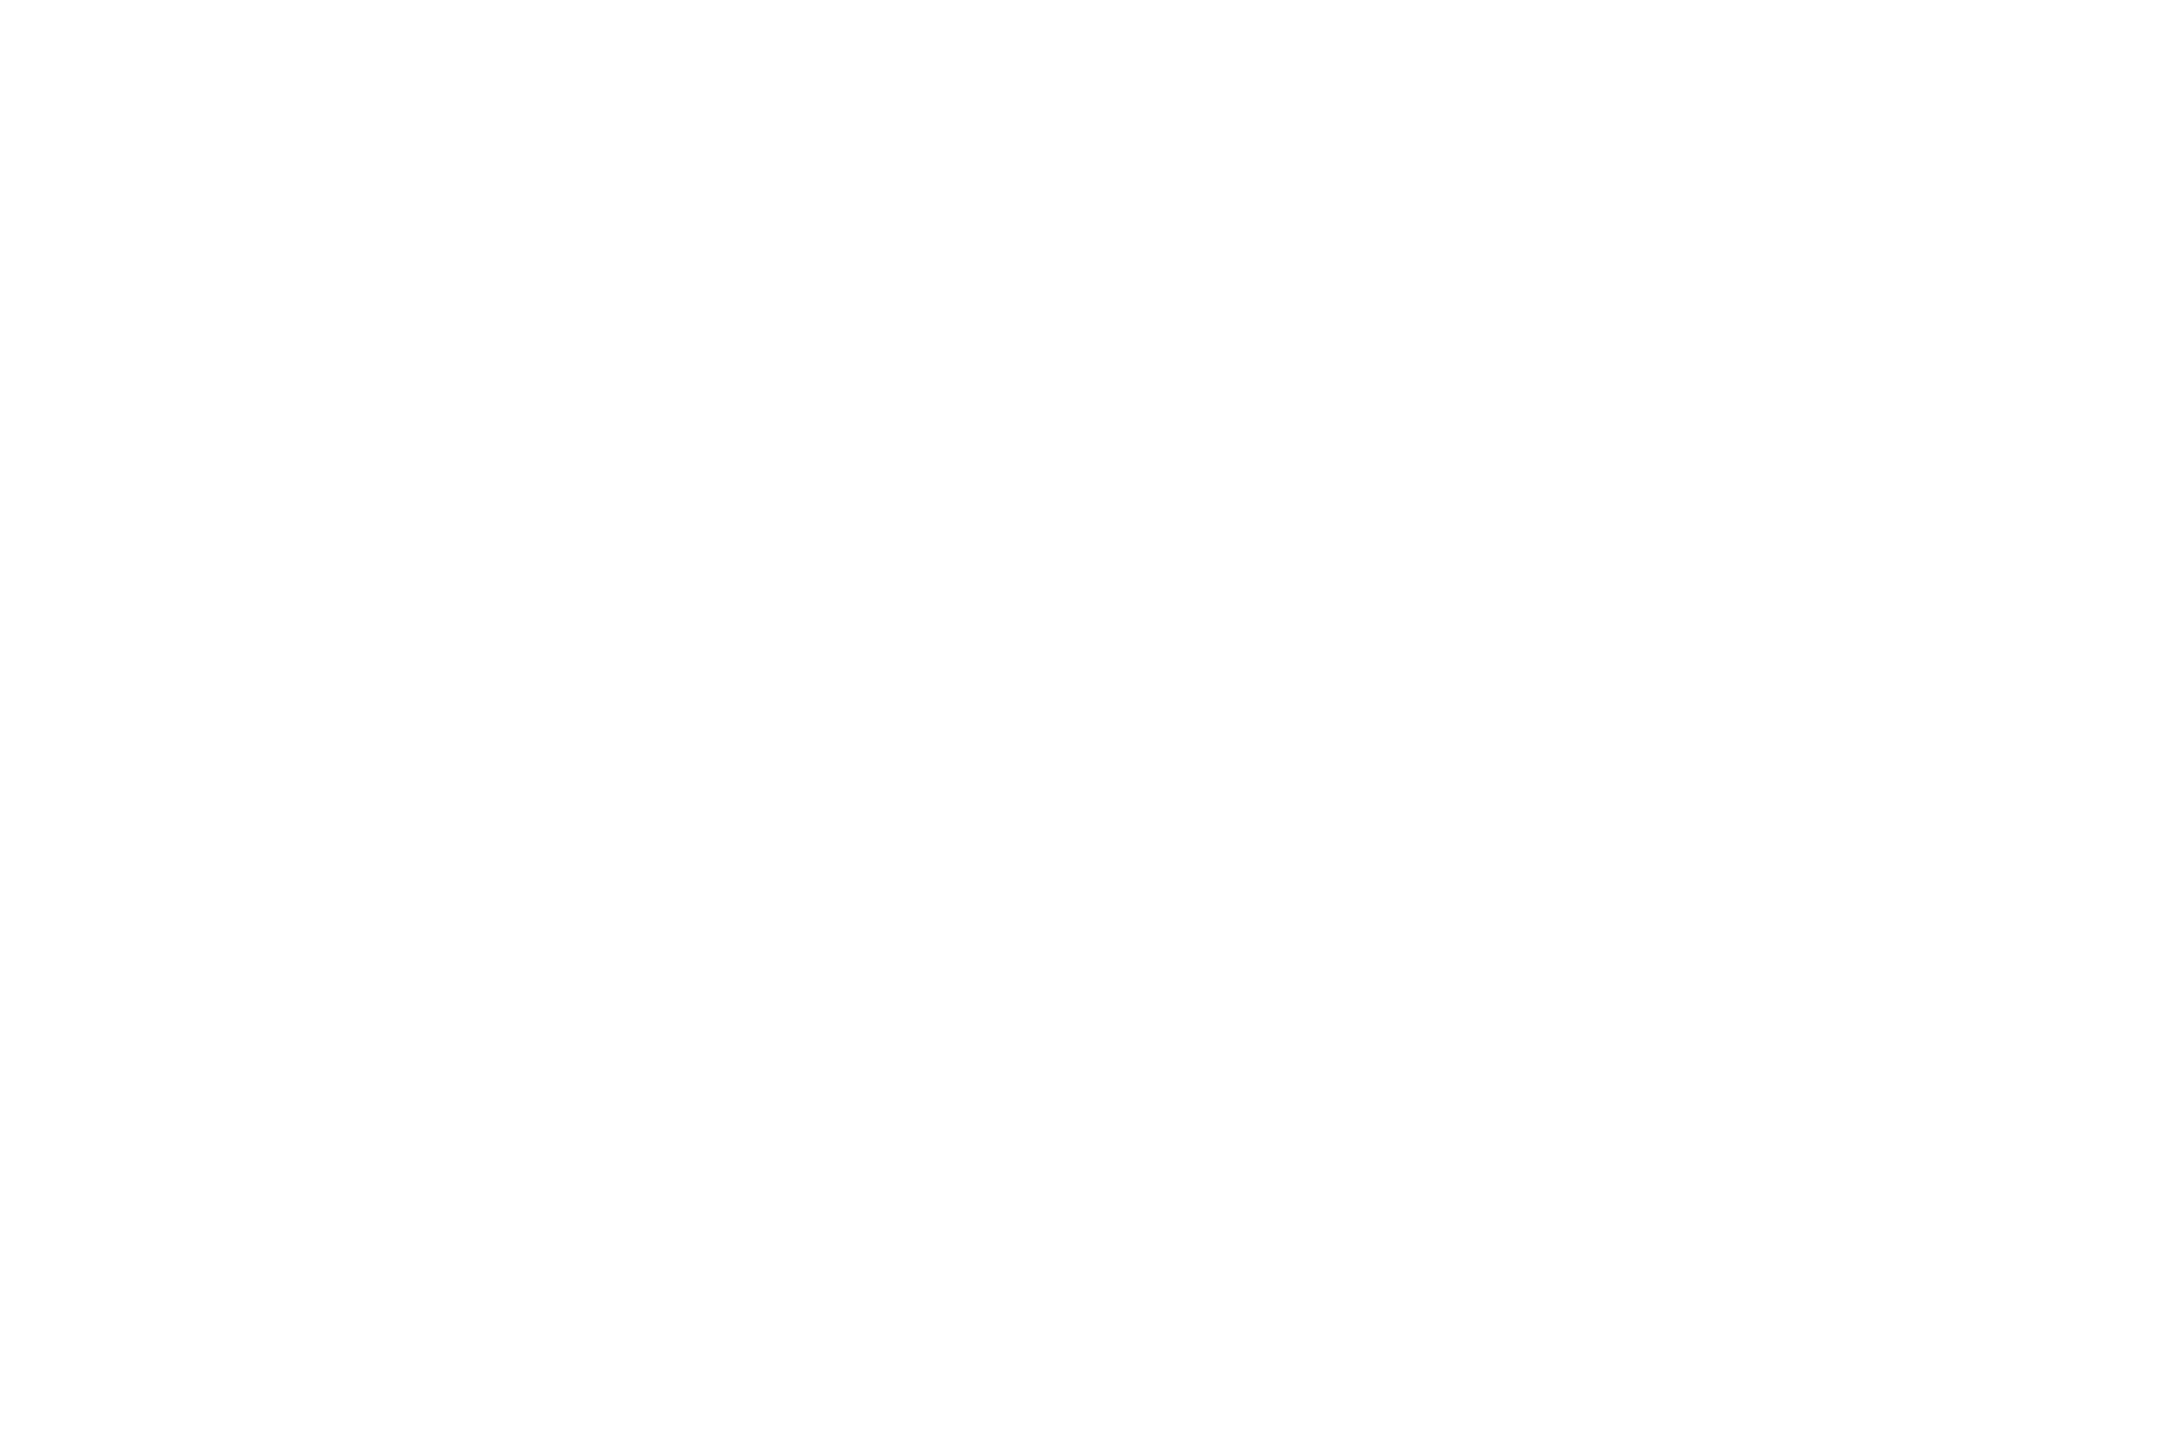

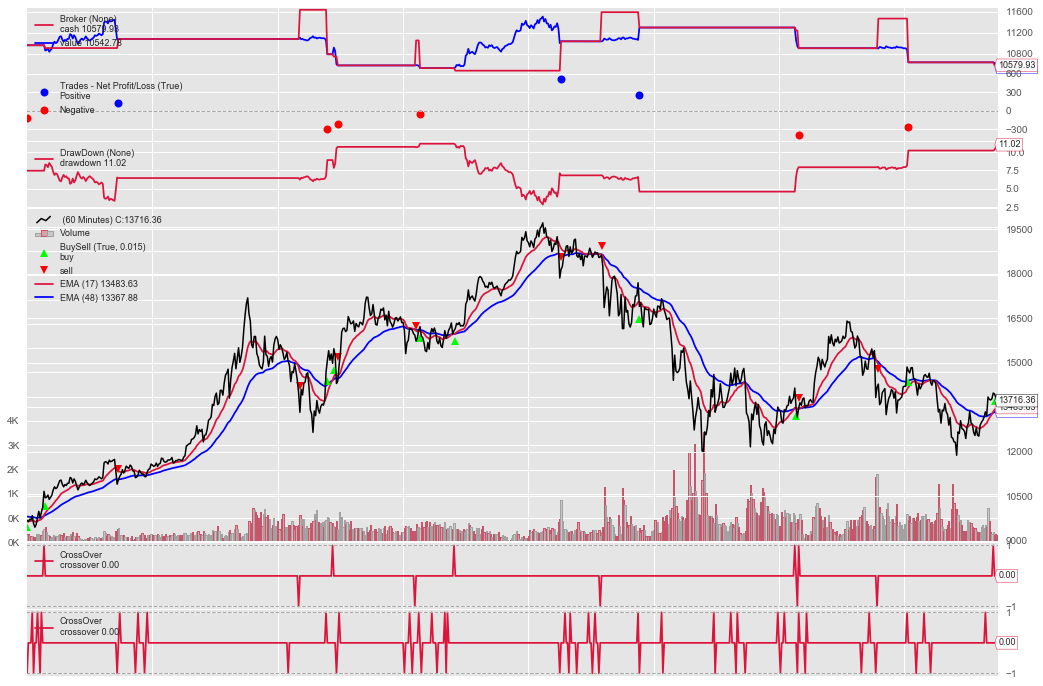

In [79]:
# Backtest for EMA and Price Crossover on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),  # multiply profits and loses (margin trading)
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )
    


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)
        self.pricecrossover = bt.ind.CrossOver(self.datas[0].close, ema_long)
        
        self.wait_to_enter = ''


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        # if an order is active, no new orders are allowed
        if self.order:
            return   
        
        # if position is not opened
        if not self.position:
            
            # if signal is go long - cross upwards
            if self.crossover > 0:
                
                # if we are waiting for a Short signal
                if self.wait_to_enter == 'wait_for_short':
                    return
                
                else: # BUY BUY BUY
                    self.log('BUY CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.buy(size=round(min((cerebro.broker.getvalue()*0.05),
                                                         500) / self.dataclose[0], 2))
                            # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
            
            # if signal is go short - cross downwards
            elif self.crossover < 0:
                
                # if we are waiting for a Long signal
                if self.wait_to_enter == 'wait_for_long':
                    return

                else:  # SELL SELL SELL
                    self.log('SELL CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.sell(size=round(min((cerebro.broker.getvalue()*0.05),
                                             500) / self.dataclose[0], 2))
                    
                             # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
        
        # if we are in the market:
        elif self.position:
            # if price signals close short == -1
            if self.pricecrossover > 0:
                self.log('CLOSE SHORT , %.2f , Wait for Long' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_long'
                self.order = self.close()
            
            # if price signals close long == 1
            elif self.pricecrossover < 0:
                self.log('CLOSE LONG , %.2f , Wait for Short' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_short'
                self.order = self.close()

                
                
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isopen:
            self.log('Trade id: {}'.format(trade.ref))
        
        elif trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 1, 1))
    
    # cerebro.plot()  # plot backtest

# 3.4 Optimise parameters for EMA and Price Crossover

In [83]:
# Parameter optimisation for EMA and Price Crossover on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', False),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)
        self.pricecrossover = bt.ind.CrossOver(self.datas[0].close, ema_long)
        
        self.wait_to_enter = ''


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        # if an order is active, no new orders are allowed
        if self.order:
            return   
        
        # if position is not opened
        if not self.position:
            
            # if signal is go long - cross upwards
            if self.crossover > 0:
                
                # if we are waiting for a Short signal
                if self.wait_to_enter == 'wait_for_short':
                    return
                
                else: # BUY BUY BUY
                    self.log('BUY CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.buy(size=round(min((cerebro.broker.getvalue()*0.05),
                                                         500) / self.dataclose[0], 2))
                            # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
            
            # if signal is go short - cross downwards
            elif self.crossover < 0:
                
                # if we are waiting for a Long signal
                if self.wait_to_enter == 'wait_for_long':
                    return

                else:  # SELL SELL SELL
                    self.log('SELL CREATE , %.2f' % self.dataclose[0])
                    self.wait_to_enter = ''
                    # to make orders at 5% of portfolio value, no more than 500$
                    self.order = self.sell(size=round(min((cerebro.broker.getvalue()*0.05),
                                             500) / self.dataclose[0], 2))
                             # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)
        
        # if we are in the market:
        elif self.position:
            # if price signals close short == -1
            if self.pricecrossover > 0:
                self.log('CLOSE SHORT , %.2f , Wait for Long' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_long'
                self.order = self.close()
            
            # if price signals close long == 1
            elif self.pricecrossover < 0:
                self.log('CLOSE LONG , %.2f , Wait for Short' % self.dataclose[0])
                self.wait_to_enter = 'wait_for_short'
                self.order = self.close()


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))
    
    
#     UNCOMMENT TO OPTIMISE
    def stop(self):
        self.log('(Short EMA %2d), (Long EMA: %2d) Ending Value %.2f' %
                 (self.params.short_ema, self.params.long_ema, self.broker.getvalue()),
                 doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        short_ema=range(15, 21),
        long_ema=range(45, 51))
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Add a Percentage sizer - set to 5% of portfolio value
    # cerebro.addsizer(bt.sizers.PercentSizer, percents=5)
    # cerebro.addsizer(bt.sizers.FixedSize)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Run over everything
    thestrats = cerebro.run(maxcpus=2)  # OPTIMIZE
    thestrat = thestrats[0]


Starting Portfolio Value: 10000.00
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 45) Ending Value 8951.21
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 46) Ending Value 8124.54
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 47) Ending Value 10137.13
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 48) Ending Value 9871.11
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 50) Ending Value 7545.39
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 49) Ending Value 10113.10
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 45) Ending Value 9983.47
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 46) Ending Value 10662.33
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 47) Ending Value 10699.30
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 48) Ending Value 10380.57
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 49) Ending Value 8726.23
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 50) Ending Value 7669.94


## EMAs (20 and 46) returned the best result (12k) followed by EMAs 20-47 and 20-49

# 3.5 Backtest Simple EMA crossover strategy

Starting Portfolio Value: 10000.00
2017-08-23T01:59:59.998997, BUY CREATE , 4100.00
2017-08-23T02:59:59.999004, BUY EXECUTED, Price: 4101.53, Cost: 492.18, Comm 0.49
2017-08-23T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 492.18
2017-08-28T04:59:59.998997, CLOSE LONG , 4227.00
2017-08-28T04:59:59.998997, SELL CREATE , 4227.00
2017-08-28T05:59:59.999004, SELL EXECUTED, Price: 4251.92, Cost: 492.18, Comm 0.58
2017-08-28T05:59:59.999004, SELL EXECUTED, Price: 4251.92, Cost: -510.23, Comm 0.51
2017-08-28T05:59:59.999004, OPERATION PROFIT, GROSS 180.47, NET 179.40, Acc Balance: 10188.84
2017-08-28T05:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -510.23
2017-08-28T19:59:59.998997, CLOSE SHORT , 4321.65
2017-08-28T19:59:59.998997, BUY CREATE , 4321.65
2017-08-28T20:59:59.999004, BUY EXECUTED, Price: 4321.65, Cost: -510.23, Comm 0.52
2017-08-28T20:59:59.999004, BUY EXECUTED, Price: 4321.65, Cost: 518.60, Comm 0.52
2017-08-28T20:59:59.999004, OPERATION PROFIT, GROSS -83.68, NET -84.70, Acc Bal

2017-11-13T13:59:59.998997, CLOSE SHORT , 6561.81
2017-11-13T13:59:59.998997, BUY CREATE , 6561.81
2017-11-13T14:59:59.999004, BUY EXECUTED, Price: 6525.40, Cost: -495.32, Comm 0.51
2017-11-13T14:59:59.999004, BUY EXECUTED, Price: 6525.40, Cost: 522.03, Comm 0.52
2017-11-13T14:59:59.999004, OPERATION PROFIT, GROSS 385.42, NET 384.41, Acc Balance: 13467.95
2017-11-13T14:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 522.03
2017-11-23T11:59:59.999004, CLOSE LONG , 8099.97
2017-11-23T11:59:59.999004, SELL CREATE , 8099.97
2017-11-23T12:59:59.999000, SELL EXECUTED, Price: 8099.95, Cost: 522.03, Comm 0.79
2017-11-23T12:59:59.999000, SELL EXECUTED, Price: 8099.95, Cost: -486.00, Comm 0.49
2017-11-23T12:59:59.999000, OPERATION PROFIT, GROSS 1259.64, NET 1258.33, Acc Balance: 14811.55
2017-11-23T12:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -486.00
2017-11-24T19:59:59.998997, CLOSE SHORT , 8224.98
2017-11-24T19:59:59.998997, BUY CREATE , 8224.98
2017-11-24T20:59:59.999004, BUY EXECUTED, Price: 8

2018-02-03T19:59:59.998997, CLOSE SHORT , 9339.43
2018-02-03T19:59:59.998997, BUY CREATE , 9339.43
2018-02-03T20:59:59.999004, BUY EXECUTED, Price: 9350.00, Cost: -450.88, Comm 0.44
2018-02-03T20:59:59.999004, BUY EXECUTED, Price: 9350.00, Cost: 467.50, Comm 0.47
2018-02-03T20:59:59.999004, OPERATION PROFIT, GROSS 768.80, NET 767.92, Acc Balance: 18316.32
2018-02-03T20:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 467.50
2018-02-04T10:59:59.998997, CLOSE LONG , 8849.97
2018-02-04T10:59:59.998997, SELL CREATE , 8849.97
2018-02-04T11:59:59.999004, SELL EXECUTED, Price: 8848.53, Cost: 467.50, Comm 0.46
2018-02-04T11:59:59.999004, SELL EXECUTED, Price: 8848.53, Cost: -530.91, Comm 0.53
2018-02-04T11:59:59.999004, OPERATION PROFIT, GROSS -250.73, NET -251.66, Acc Balance: 18097.31
2018-02-04T11:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -530.91
2018-02-07T08:59:59.999004, CLOSE SHORT , 7654.85
2018-02-07T08:59:59.999004, BUY CREATE , 7654.85
2018-02-07T09:59:59.999000, BUY EXECUTED, Price: 7

2018-04-25T15:59:59.999000, CLOSE LONG , 8972.09
2018-04-25T15:59:59.999000, SELL CREATE , 8972.09
2018-04-25T16:59:59.998997, SELL EXECUTED, Price: 8972.09, Cost: 486.84, Comm 0.63
2018-04-25T16:59:59.998997, SELL EXECUTED, Price: 8972.09, Cost: -538.33, Comm 0.54
2018-04-25T16:59:59.998997, OPERATION PROFIT, GROSS 514.90, NET 513.78, Acc Balance: 22172.27
2018-04-25T16:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -538.33
2018-04-27T01:59:59.998997, CLOSE SHORT , 9249.97
2018-04-27T01:59:59.998997, BUY CREATE , 9249.97
2018-04-27T02:59:59.999004, BUY EXECUTED, Price: 9240.00, Cost: -538.33, Comm 0.58
2018-04-27T02:59:59.999004, BUY EXECUTED, Price: 9240.00, Cost: 462.00, Comm 0.46
2018-04-27T02:59:59.999004, OPERATION PROFIT, GROSS -160.75, NET -161.87, Acc Balance: 22013.80
2018-04-27T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 462.00
2018-04-28T02:59:59.999004, CLOSE LONG , 9055.78
2018-04-28T02:59:59.999004, SELL CREATE , 9055.78
2018-04-28T03:59:59.999000, SELL EXECUTED, Price: 

2018-06-04T11:59:59.999004, CLOSE LONG , 7505.00
2018-06-04T11:59:59.999004, SELL CREATE , 7505.00
2018-06-04T12:59:59.999000, SELL EXECUTED, Price: 7505.00, Cost: 526.47, Comm 0.55
2018-06-04T12:59:59.999000, SELL EXECUTED, Price: 7505.00, Cost: -525.35, Comm 0.53
2018-06-04T12:59:59.999000, OPERATION PROFIT, GROSS -11.21, NET -12.29, Acc Balance: 22191.01
2018-06-04T12:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -525.35
2018-06-05T22:59:59.998997, CLOSE SHORT , 7637.99
2018-06-05T22:59:59.998997, BUY CREATE , 7637.99
2018-06-05T23:59:59.999004, BUY EXECUTED, Price: 7637.98, Cost: -525.35, Comm 0.55
2018-06-05T23:59:59.999004, BUY EXECUTED, Price: 7637.98, Cost: 534.66, Comm 0.53
2018-06-05T23:59:59.999004, OPERATION PROFIT, GROSS -93.09, NET -94.16, Acc Balance: 22090.02
2018-06-05T23:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 534.66
2018-06-08T10:59:59.998997, CLOSE LONG , 7564.06
2018-06-08T10:59:59.998997, SELL CREATE , 7564.06
2018-06-08T11:59:59.999004, SELL EXECUTED, Price: 75

2018-08-19T21:59:59.999000, CLOSE SHORT , 6484.08
2018-08-19T21:59:59.999000, BUY CREATE , 6484.08
2018-08-19T22:59:59.998997, BUY EXECUTED, Price: 6486.80, Cost: -507.04, Comm 0.53
2018-08-19T22:59:59.998997, BUY EXECUTED, Price: 6486.80, Cost: 518.94, Comm 0.52
2018-08-19T22:59:59.998997, OPERATION PROFIT, GROSS -119.03, NET -120.07, Acc Balance: 23661.59
2018-08-19T22:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 518.94
2018-08-20T22:59:59.998997, CLOSE LONG , 6297.68
2018-08-20T22:59:59.998997, SELL CREATE , 6297.68
2018-08-20T23:59:59.999004, SELL EXECUTED, Price: 6295.08, Cost: 518.94, Comm 0.52
2018-08-20T23:59:59.999004, SELL EXECUTED, Price: 6295.08, Cost: -503.61, Comm 0.50
2018-08-20T23:59:59.999004, OPERATION PROFIT, GROSS -153.38, NET -154.41, Acc Balance: 23487.00
2018-08-20T23:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -503.61
2018-08-21T18:59:59.999000, CLOSE SHORT , 6450.00
2018-08-21T18:59:59.999000, BUY CREATE , 6450.00
2018-08-21T19:59:59.998997, BUY EXECUTED, Price:

2018-09-29T04:59:59.998997, CLOSE LONG , 6509.00
2018-09-29T04:59:59.998997, SELL CREATE , 6509.00
2018-09-29T05:59:59.999004, SELL EXECUTED, Price: 6509.01, Cost: 521.01, Comm 0.55
2018-09-29T05:59:59.999004, SELL EXECUTED, Price: 6509.01, Cost: -520.72, Comm 0.52
2018-09-29T05:59:59.999004, OPERATION PROFIT, GROSS -2.86, NET -3.93, Acc Balance: 23784.86
2018-09-29T05:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -520.72
2018-09-30T10:59:59.998997, CLOSE SHORT , 6637.98
2018-09-30T10:59:59.998997, BUY CREATE , 6637.98
2018-09-30T11:59:59.999004, BUY EXECUTED, Price: 6637.98, Cost: -520.72, Comm 0.55
2018-09-30T11:59:59.999004, BUY EXECUTED, Price: 6637.98, Cost: 531.04, Comm 0.53
2018-09-30T11:59:59.999004, OPERATION PROFIT, GROSS -103.18, NET -104.24, Acc Balance: 23673.01
2018-09-30T11:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 531.04
2018-10-01T14:59:59.999004, CLOSE LONG , 6567.97
2018-10-01T14:59:59.999004, SELL CREATE , 6567.97
2018-10-01T15:59:59.999000, SELL EXECUTED, Price: 65

2018-12-25T01:59:59.998997, CLOSE LONG , 3800.01
2018-12-25T01:59:59.998997, SELL CREATE , 3800.01
2018-12-25T02:59:59.999004, SELL EXECUTED, Price: 3800.03, Cost: 517.05, Comm 0.52
2018-12-25T02:59:59.999004, SELL EXECUTED, Price: 3800.03, Cost: -494.00, Comm 0.49
2018-12-25T02:59:59.999004, OPERATION PROFIT, GROSS -230.48, NET -231.52, Acc Balance: 25907.68
2018-12-25T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -494.00
2018-12-28T19:59:59.998997, CLOSE SHORT , 3819.54
2018-12-28T19:59:59.998997, BUY CREATE , 3819.54
2018-12-28T20:59:59.999004, BUY EXECUTED, Price: 3821.88, Cost: -494.00, Comm 0.54
2018-12-28T20:59:59.999004, BUY EXECUTED, Price: 3821.88, Cost: 496.84, Comm 0.50
2018-12-28T20:59:59.999004, OPERATION PROFIT, GROSS -28.40, NET -29.44, Acc Balance: 25907.97
2018-12-28T20:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 496.84
2018-12-30T05:59:59.999004, CLOSE LONG , 3732.45
2018-12-30T05:59:59.999004, SELL CREATE , 3732.45
2018-12-30T06:59:59.999000, SELL EXECUTED, Price: 

2019-01-27T07:59:59.998997, CLOSE LONG , 3562.01
2019-01-27T07:59:59.998997, SELL CREATE , 3562.01
2019-01-27T08:59:59.999004, SELL EXECUTED, Price: 3562.77, Cost: 499.76, Comm 0.53
2019-01-27T08:59:59.999004, SELL EXECUTED, Price: 3562.77, Cost: -498.79, Comm 0.50
2019-01-27T08:59:59.999004, OPERATION PROFIT, GROSS -9.74, NET -10.77, Acc Balance: 24818.22
2019-01-27T08:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -498.79
2019-01-30T15:59:59.999000, CLOSE SHORT , 3464.01
2019-01-30T15:59:59.999000, BUY CREATE , 3464.01
2019-01-30T16:59:59.998997, BUY EXECUTED, Price: 3464.03, Cost: -498.79, Comm 0.53
2019-01-30T16:59:59.998997, BUY EXECUTED, Price: 3464.03, Cost: 484.96, Comm 0.48
2019-01-30T16:59:59.998997, OPERATION PROFIT, GROSS 138.24, NET 137.21, Acc Balance: 24948.97
2019-01-30T16:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 484.96
2019-01-31T15:59:59.999000, CLOSE LONG , 3436.56
2019-01-31T15:59:59.999000, SELL CREATE , 3436.56
2019-01-31T16:59:59.998997, SELL EXECUTED, Price: 343

2019-03-11T07:59:59.998997, CLOSE LONG , 3885.50
2019-03-11T07:59:59.998997, SELL CREATE , 3885.50
2019-03-11T08:59:59.999004, SELL EXECUTED, Price: 3885.49, Cost: 498.55, Comm 0.59
2019-03-11T08:59:59.999004, SELL EXECUTED, Price: 3885.49, Cost: -505.11, Comm 0.51
2019-03-11T08:59:59.999004, OPERATION PROFIT, GROSS 65.64, NET 64.55, Acc Balance: 24789.40
2019-03-11T08:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -505.11
2019-03-14T22:59:59.998997, CLOSE SHORT , 3876.54
2019-03-14T22:59:59.998997, BUY CREATE , 3876.54
2019-03-14T23:59:59.999004, BUY EXECUTED, Price: 3876.48, Cost: -505.11, Comm 0.55
2019-03-14T23:59:59.999004, BUY EXECUTED, Price: 3876.48, Cost: 503.94, Comm 0.50
2019-03-14T23:59:59.999004, OPERATION PROFIT, GROSS 11.71, NET 10.66, Acc Balance: 24800.98
2019-03-14T23:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 503.94
2019-03-21T16:59:59.998997, CLOSE LONG , 3967.11
2019-03-21T16:59:59.998997, SELL CREATE , 3967.11
2019-03-21T17:59:59.999004, SELL EXECUTED, Price: 3967.1

2019-06-07T08:59:59.999004, CLOSE SHORT , 7954.27
2019-06-07T08:59:59.999004, BUY CREATE , 7954.27
2019-06-07T09:59:59.999000, BUY EXECUTED, Price: 7954.25, Cost: -508.83, Comm 0.53
2019-06-07T09:59:59.999000, BUY EXECUTED, Price: 7954.25, Cost: 477.25, Comm 0.48
2019-06-07T09:59:59.999000, OPERATION PROFIT, GROSS 315.70, NET 314.66, Acc Balance: 27459.15
2019-06-07T09:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 477.25
2019-06-08T19:59:59.998997, CLOSE LONG , 7809.25
2019-06-08T19:59:59.998997, SELL CREATE , 7809.25
2019-06-08T20:59:59.999004, SELL EXECUTED, Price: 7810.54, Cost: 477.25, Comm 0.48
2019-06-08T20:59:59.999004, SELL EXECUTED, Price: 7810.54, Cost: -468.63, Comm 0.47
2019-06-08T20:59:59.999004, OPERATION PROFIT, GROSS -86.23, NET -87.18, Acc Balance: 27380.95
2019-06-08T20:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -468.63
2019-06-10T15:59:59.999000, CLOSE SHORT , 7914.45
2019-06-10T15:59:59.999000, BUY CREATE , 7914.45
2019-06-10T16:59:59.998997, BUY EXECUTED, Price: 791

2019-07-16T08:59:59.999004, CLOSE SHORT , 10801.00
2019-07-16T08:59:59.999004, BUY CREATE , 10801.00
2019-07-16T09:59:59.999000, BUY EXECUTED, Price: 10801.00, Cost: -478.80, Comm 0.51
2019-07-16T09:59:59.999000, BUY EXECUTED, Price: 10801.00, Cost: 540.05, Comm 0.54
2019-07-16T09:59:59.999000, OPERATION PROFIT, GROSS 467.56, NET 466.57, Acc Balance: 28080.75
2019-07-16T09:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 540.05
2019-07-16T10:59:59.998997, CLOSE LONG , 10684.21
2019-07-16T10:59:59.998997, SELL CREATE , 10684.21
2019-07-16T11:59:59.999004, SELL EXECUTED, Price: 10684.21, Cost: 540.05, Comm 0.53
2019-07-16T11:59:59.999004, SELL EXECUTED, Price: 10684.21, Cost: -534.21, Comm 0.53
2019-07-16T11:59:59.999004, OPERATION PROFIT, GROSS -58.40, NET -59.47, Acc Balance: 28080.06
2019-07-16T11:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -534.21
2019-07-18T16:59:59.998997, CLOSE SHORT , 10483.61
2019-07-18T16:59:59.998997, BUY CREATE , 10483.61
2019-07-18T17:59:59.999004, BUY EXECUTED, 

<IPython.core.display.Javascript object>


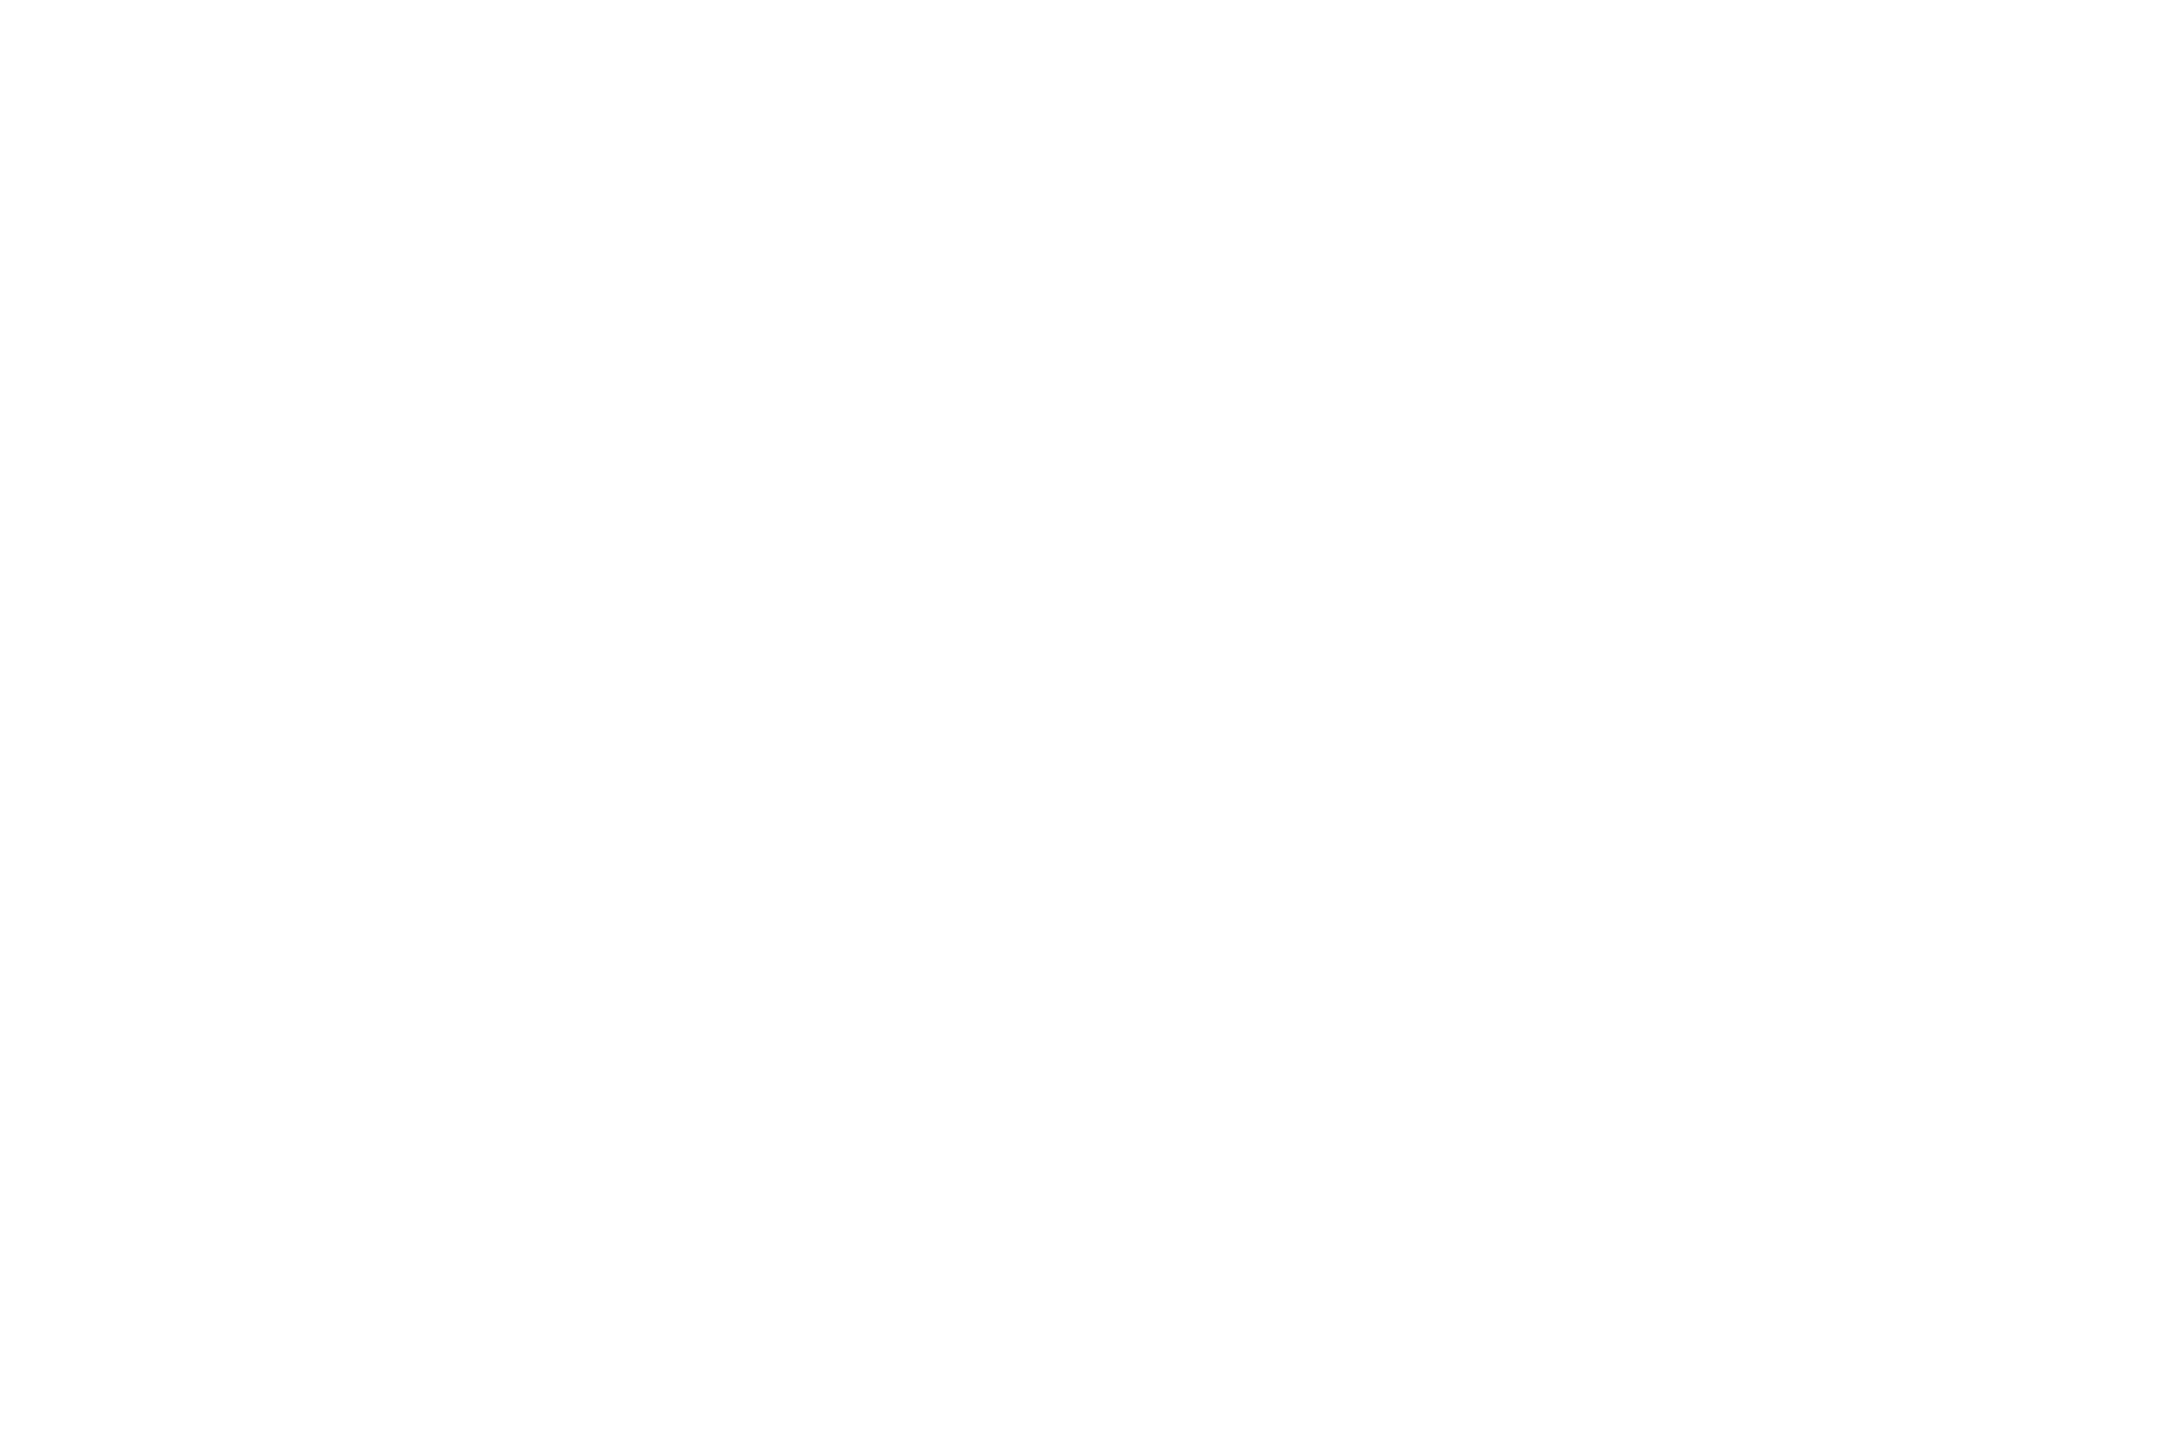

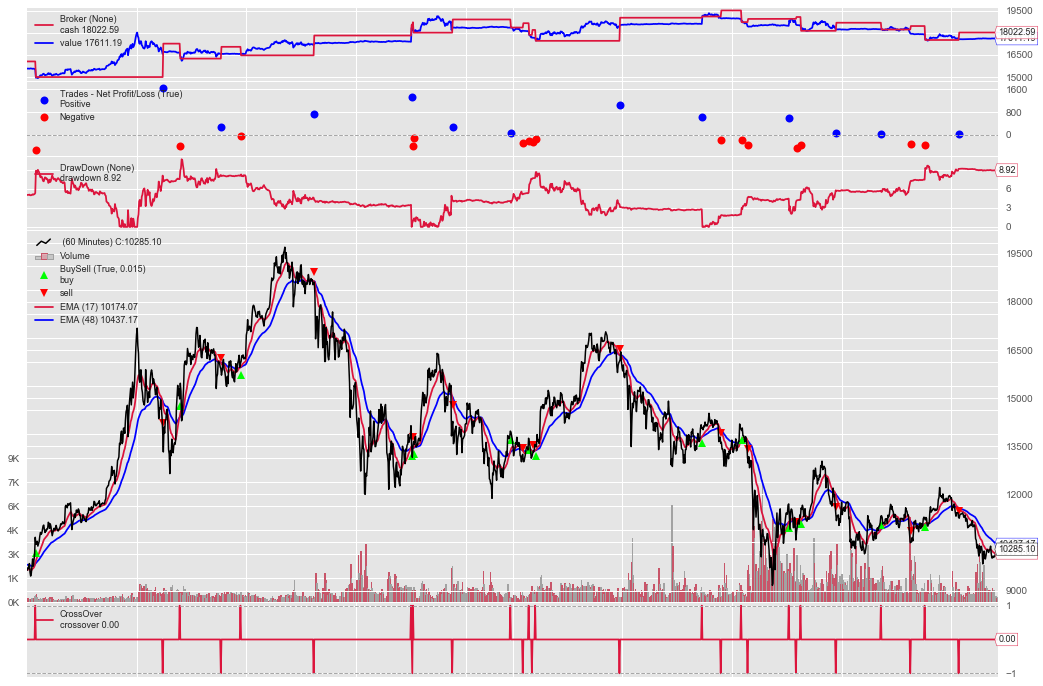

In [63]:
# Simple EMA Crossover on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest

# 3.6 Optimise Simple EMA crossover strategy parameters

In [64]:
# Parameter optimisation for Simple EMA crossover strategy on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 17),
        ('long_ema', 48),
        ('mult', 10),
        ('lever', 10),
        ('printlog', False),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))
    
    
#     UNCOMMENT TO OPTIMISE
    def stop(self):
        self.log('(Short EMA %2d), (Long EMA: %2d) Ending Value %.2f' %
                 (self.params.short_ema, self.params.long_ema, self.broker.getvalue()),
                 doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        short_ema=range(15, 21),
        long_ema=range(45, 51))
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Add a Percentage sizer - set to 5% of portfolio value
    # cerebro.addsizer(bt.sizers.PercentSizer, percents=5)
    # cerebro.addsizer(bt.sizers.FixedSize)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Run over everything
    thestrats = cerebro.run(maxcpus=2)  # OPTIMIZE
    thestrat = thestrats[0]


Starting Portfolio Value: 10000.00
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 45) Ending Value 26737.75
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 46) Ending Value 27275.80
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 48) Ending Value 28367.43
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 47) Ending Value 27495.57
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 49) Ending Value 28741.00
2019-08-20T20:59:59.999004, (Short EMA 15), (Long EMA: 50) Ending Value 29201.26
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 45) Ending Value 28116.24
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 46) Ending Value 28495.78
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 48) Ending Value 29152.89
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 47) Ending Value 28750.19
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 49) Ending Value 30502.90
2019-08-20T20:59:59.999004, (Short EMA 16), (Long EMA: 50) Ending Value 27

### The performance didn't improve as much as in case of Ether but 16 and 49 gave us a bit of extra profit.

# 3.7 Backtest with optimised parameters for simple EMA crossover

Starting Portfolio Value: 10000.00
2017-08-23T01:59:59.998997, BUY CREATE , 4100.00
2017-08-23T02:59:59.999004, BUY EXECUTED, Price: 4101.53, Cost: 492.18, Comm 0.49
2017-08-23T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 492.18
2017-08-28T04:59:59.998997, CLOSE LONG , 4227.00
2017-08-28T04:59:59.998997, SELL CREATE , 4227.00
2017-08-28T05:59:59.999004, SELL EXECUTED, Price: 4251.92, Cost: 492.18, Comm 0.58
2017-08-28T05:59:59.999004, SELL EXECUTED, Price: 4251.92, Cost: -510.23, Comm 0.51
2017-08-28T05:59:59.999004, OPERATION PROFIT, GROSS 180.47, NET 179.40, Acc Balance: 10188.84
2017-08-28T05:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -510.23
2017-08-28T19:59:59.998997, CLOSE SHORT , 4321.65
2017-08-28T19:59:59.998997, BUY CREATE , 4321.65
2017-08-28T20:59:59.999004, BUY EXECUTED, Price: 4321.65, Cost: -510.23, Comm 0.52
2017-08-28T20:59:59.999004, BUY EXECUTED, Price: 4321.65, Cost: 518.60, Comm 0.52
2017-08-28T20:59:59.999004, OPERATION PROFIT, GROSS -83.68, NET -84.70, Acc Bal

2017-11-13T13:59:59.998997, CLOSE SHORT , 6561.81
2017-11-13T13:59:59.998997, BUY CREATE , 6561.81
2017-11-13T14:59:59.999004, BUY EXECUTED, Price: 6525.40, Cost: -495.32, Comm 0.51
2017-11-13T14:59:59.999004, BUY EXECUTED, Price: 6525.40, Cost: 522.03, Comm 0.52
2017-11-13T14:59:59.999004, OPERATION PROFIT, GROSS 385.42, NET 384.41, Acc Balance: 13593.63
2017-11-13T14:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 522.03
2017-11-23T11:59:59.999004, CLOSE LONG , 8099.97
2017-11-23T11:59:59.999004, SELL CREATE , 8099.97
2017-11-23T12:59:59.999000, SELL EXECUTED, Price: 8099.95, Cost: 522.03, Comm 0.79
2017-11-23T12:59:59.999000, SELL EXECUTED, Price: 8099.95, Cost: -486.00, Comm 0.49
2017-11-23T12:59:59.999000, OPERATION PROFIT, GROSS 1259.64, NET 1258.33, Acc Balance: 14937.23
2017-11-23T12:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -486.00
2017-11-24T19:59:59.998997, CLOSE SHORT , 8224.98
2017-11-24T19:59:59.998997, BUY CREATE , 8224.98
2017-11-24T20:59:59.999004, BUY EXECUTED, Price: 8

2018-02-07T08:59:59.999004, CLOSE SHORT , 7654.85
2018-02-07T08:59:59.999004, BUY CREATE , 7654.85
2018-02-07T09:59:59.999000, BUY EXECUTED, Price: 7654.92, Cost: -530.91, Comm 0.50
2018-02-07T09:59:59.999000, BUY EXECUTED, Price: 7654.92, Cost: 535.84, Comm 0.54
2018-02-07T09:59:59.999000, OPERATION PROFIT, GROSS 716.17, NET 715.13, Acc Balance: 19754.63
2018-02-07T09:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 535.84
2018-02-11T04:00:00.998995, CLOSE LONG , 7976.74
2018-02-11T04:00:00.998995, SELL CREATE , 7976.74
2018-02-11T04:59:59.998997, SELL EXECUTED, Price: 7976.74, Cost: 535.84, Comm 0.62
2018-02-11T04:59:59.998997, SELL EXECUTED, Price: 7976.74, Cost: -478.60, Comm 0.48
2018-02-11T04:59:59.998997, OPERATION PROFIT, GROSS 225.27, NET 224.12, Acc Balance: 19785.71
2018-02-11T04:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -478.60
2018-02-12T02:59:59.999004, CLOSE SHORT , 8518.00
2018-02-12T02:59:59.999004, BUY CREATE , 8518.00
2018-02-12T03:59:59.999000, BUY EXECUTED, Price: 851

2018-04-30T09:59:59.999000, CLOSE LONG , 9219.97
2018-04-30T09:59:59.999000, SELL CREATE , 9219.97
2018-04-30T10:59:59.998997, SELL EXECUTED, Price: 9219.97, Cost: 456.93, Comm 0.49
2018-04-30T10:59:59.998997, SELL EXECUTED, Price: 9219.97, Cost: -461.00, Comm 0.46
2018-04-30T10:59:59.998997, OPERATION PROFIT, GROSS 40.71, NET 39.77, Acc Balance: 22757.84
2018-04-30T10:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -461.00
2018-04-30T18:59:59.999000, CLOSE SHORT , 9350.00
2018-04-30T18:59:59.999000, BUY CREATE , 9350.00
2018-04-30T19:59:59.998997, BUY EXECUTED, Price: 9351.00, Cost: -461.00, Comm 0.47
2018-04-30T19:59:59.998997, BUY EXECUTED, Price: 9351.00, Cost: 467.55, Comm 0.47
2018-04-30T19:59:59.998997, OPERATION PROFIT, GROSS -65.52, NET -66.44, Acc Balance: 22687.52
2018-04-30T19:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 467.55
2018-04-30T21:59:59.999000, CLOSE LONG , 9218.39
2018-04-30T21:59:59.999000, SELL CREATE , 9218.39
2018-04-30T22:59:59.998997, SELL EXECUTED, Price: 9221

2018-06-08T10:59:59.998997, CLOSE LONG , 7564.06
2018-06-08T10:59:59.998997, SELL CREATE , 7564.06
2018-06-08T11:59:59.999004, SELL EXECUTED, Price: 7559.13, Cost: 531.16, Comm 0.57
2018-06-08T11:59:59.999004, SELL EXECUTED, Price: 7559.13, Cost: -529.14, Comm 0.53
2018-06-08T11:59:59.999004, OPERATION PROFIT, GROSS -20.24, NET -21.35, Acc Balance: 22939.62
2018-06-08T11:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -529.14
2018-06-09T03:59:59.999000, CLOSE SHORT , 7661.15
2018-06-09T03:59:59.999000, BUY CREATE , 7661.15
2018-06-09T04:59:59.998997, BUY EXECUTED, Price: 7662.68, Cost: -529.14, Comm 0.55
2018-06-09T04:59:59.998997, BUY EXECUTED, Price: 7662.68, Cost: 536.39, Comm 0.54
2018-06-09T04:59:59.998997, OPERATION PROFIT, GROSS -72.48, NET -73.57, Acc Balance: 22859.87
2018-06-09T04:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 536.39
2018-06-09T12:59:59.999000, CLOSE LONG , 7603.15
2018-06-09T12:59:59.999000, SELL CREATE , 7603.15
2018-06-09T13:59:59.998997, SELL EXECUTED, Price: 76

2018-07-21T01:59:59.998997, CLOSE LONG , 7269.23
2018-07-21T01:59:59.998997, SELL CREATE , 7269.23
2018-07-21T02:59:59.999004, SELL EXECUTED, Price: 7269.22, Cost: 500.64, Comm 0.66
2018-07-21T02:59:59.999004, SELL EXECUTED, Price: 7269.22, Cost: -508.85, Comm 0.51
2018-07-21T02:59:59.999004, OPERATION PROFIT, GROSS 808.98, NET 807.82, Acc Balance: 24144.31
2018-07-21T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -508.85
2018-07-21T17:59:59.999004, CLOSE SHORT , 7414.49
2018-07-21T17:59:59.999004, BUY CREATE , 7414.49
2018-07-21T18:59:59.999000, BUY EXECUTED, Price: 7412.75, Cost: -508.85, Comm 0.52
2018-07-21T18:59:59.999000, BUY EXECUTED, Price: 7412.75, Cost: 518.89, Comm 0.52
2018-07-21T18:59:59.999000, OPERATION PROFIT, GROSS -100.47, NET -101.50, Acc Balance: 24056.99
2018-07-21T18:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 518.89
2018-07-26T22:59:59.998997, CLOSE LONG , 7915.00
2018-07-26T22:59:59.998997, SELL CREATE , 7915.00
2018-07-26T23:59:59.999004, SELL EXECUTED, Price: 

2018-10-07T07:59:59.998997, CLOSE LONG , 6570.93
2018-10-07T07:59:59.998997, SELL CREATE , 6570.93
2018-10-07T08:59:59.999004, SELL EXECUTED, Price: 6569.46, Cost: 528.48, Comm 0.57
2018-10-07T08:59:59.999004, SELL EXECUTED, Price: 6569.46, Cost: -525.56, Comm 0.53
2018-10-07T08:59:59.999004, OPERATION PROFIT, GROSS -29.23, NET -30.33, Acc Balance: 24663.90
2018-10-07T08:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -525.56
2018-10-08T00:59:59.999000, CLOSE SHORT , 6613.90
2018-10-08T00:59:59.999000, BUY CREATE , 6613.90
2018-10-08T01:59:59.998997, BUY EXECUTED, Price: 6615.67, Cost: -525.56, Comm 0.54
2018-10-08T01:59:59.998997, BUY EXECUTED, Price: 6615.67, Cost: 529.25, Comm 0.53
2018-10-08T01:59:59.998997, OPERATION PROFIT, GROSS -36.97, NET -38.04, Acc Balance: 24616.55
2018-10-08T01:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 529.25
2018-10-10T04:59:59.998997, CLOSE LONG , 6594.40
2018-10-10T04:59:59.998997, SELL CREATE , 6594.40
2018-10-10T05:59:59.999004, SELL EXECUTED, Price: 65

2019-01-10T06:59:59.999000, CLOSE LONG , 3781.31
2019-01-10T06:59:59.999000, SELL CREATE , 3781.31
2019-01-10T07:59:59.998997, SELL EXECUTED, Price: 3779.63, Cost: 492.85, Comm 0.55
2019-01-10T07:59:59.998997, SELL EXECUTED, Price: 3779.63, Cost: -491.35, Comm 0.49
2019-01-10T07:59:59.998997, OPERATION PROFIT, GROSS -14.94, NET -15.98, Acc Balance: 26494.94
2019-01-10T07:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: -491.35
2019-01-14T18:59:59.999000, CLOSE SHORT , 3628.01
2019-01-14T18:59:59.999000, BUY CREATE , 3628.01
2019-01-14T19:59:59.998997, BUY EXECUTED, Price: 3629.32, Cost: -491.35, Comm 0.53
2019-01-14T19:59:59.998997, BUY EXECUTED, Price: 3629.32, Cost: 508.10, Comm 0.51
2019-01-14T19:59:59.998997, OPERATION PROFIT, GROSS 195.40, NET 194.39, Acc Balance: 26700.13
2019-01-14T19:59:59.998997, TRADE OPENED, SIZE:  0 , VAL: 508.10
2019-01-15T23:59:59.999004, CLOSE LONG , 3553.06
2019-01-15T23:59:59.999004, SELL CREATE , 3553.06
2019-01-16T00:59:59.999000, SELL EXECUTED, Price: 35

2019-02-12T02:59:59.999004, CLOSE LONG , 3613.39
2019-02-12T02:59:59.999004, SELL CREATE , 3613.39
2019-02-12T03:59:59.999000, SELL EXECUTED, Price: 3614.46, Cost: 515.87, Comm 0.60
2019-02-12T03:59:59.999000, SELL EXECUTED, Price: 3614.46, Cost: -506.02, Comm 0.51
2019-02-12T03:59:59.999000, OPERATION PROFIT, GROSS 263.04, NET 261.93, Acc Balance: 26024.52
2019-02-12T03:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -506.02
2019-02-12T20:59:59.999004, CLOSE SHORT , 3647.64
2019-02-12T20:59:59.999004, BUY CREATE , 3647.64
2019-02-12T21:59:59.999000, BUY EXECUTED, Price: 3647.62, Cost: -506.02, Comm 0.51
2019-02-12T21:59:59.999000, BUY EXECUTED, Price: 3647.62, Cost: 510.67, Comm 0.51
2019-02-12T21:59:59.999000, OPERATION PROFIT, GROSS -46.42, NET -47.44, Acc Balance: 25942.48
2019-02-12T21:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: 510.67
2019-02-12T22:59:59.998997, CLOSE LONG , 3620.64
2019-02-12T22:59:59.998997, SELL CREATE , 3620.64
2019-02-12T23:59:59.999004, SELL EXECUTED, Price: 36

2019-05-06T04:59:59.998997, CLOSE LONG , 5730.72
2019-05-06T04:59:59.998997, SELL CREATE , 5730.72
2019-05-06T05:59:59.999004, SELL EXECUTED, Price: 5731.00, Cost: 477.76, Comm 0.59
2019-05-06T05:59:59.999004, SELL EXECUTED, Price: 5731.00, Cost: -515.79, Comm 0.52
2019-05-06T05:59:59.999004, OPERATION PROFIT, GROSS 380.31, NET 379.24, Acc Balance: 27057.72
2019-05-06T05:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: -515.79
2019-05-06T19:59:59.998997, CLOSE SHORT , 5790.41
2019-05-06T19:59:59.998997, BUY CREATE , 5790.41
2019-05-06T20:59:59.999004, BUY EXECUTED, Price: 5790.35, Cost: -515.79, Comm 0.52
2019-05-06T20:59:59.999004, BUY EXECUTED, Price: 5790.35, Cost: 521.13, Comm 0.52
2019-05-06T20:59:59.999004, OPERATION PROFIT, GROSS -53.42, NET -54.45, Acc Balance: 26973.03
2019-05-06T20:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 521.13
2019-05-16T22:59:59.998997, CLOSE LONG , 7828.42
2019-05-16T22:59:59.998997, SELL CREATE , 7828.42
2019-05-16T23:59:59.999004, SELL EXECUTED, Price: 78

2019-07-27T01:59:59.998997, BUY CREATE , 10086.80
2019-07-27T02:59:59.999004, BUY EXECUTED, Price: 10086.80, Cost: -494.14, Comm 0.53
2019-07-27T02:59:59.999004, BUY EXECUTED, Price: 10086.80, Cost: 504.34, Comm 0.50
2019-07-27T02:59:59.999004, OPERATION PROFIT, GROSS -101.97, NET -103.00, Acc Balance: 29875.01
2019-07-27T02:59:59.999004, TRADE OPENED, SIZE:  0 , VAL: 504.34
2019-07-27T11:59:59.999004, CLOSE LONG , 9525.81
2019-07-27T11:59:59.999004, SELL CREATE , 9525.81
2019-07-27T12:59:59.999000, SELL EXECUTED, Price: 9525.81, Cost: 504.34, Comm 0.48
2019-07-27T12:59:59.999000, SELL EXECUTED, Price: 9525.81, Cost: -476.29, Comm 0.48
2019-07-27T12:59:59.999000, OPERATION PROFIT, GROSS -280.49, NET -281.48, Acc Balance: 29588.82
2019-07-27T12:59:59.999000, TRADE OPENED, SIZE:  0 , VAL: -476.29
2019-07-30T16:59:59.998997, CLOSE SHORT , 9684.85
2019-07-30T16:59:59.998997, BUY CREATE , 9684.85
2019-07-30T17:59:59.999004, BUY EXECUTED, Price: 9684.85, Cost: -476.29, Comm 0.52
2019-07-30T1

<IPython.core.display.Javascript object>


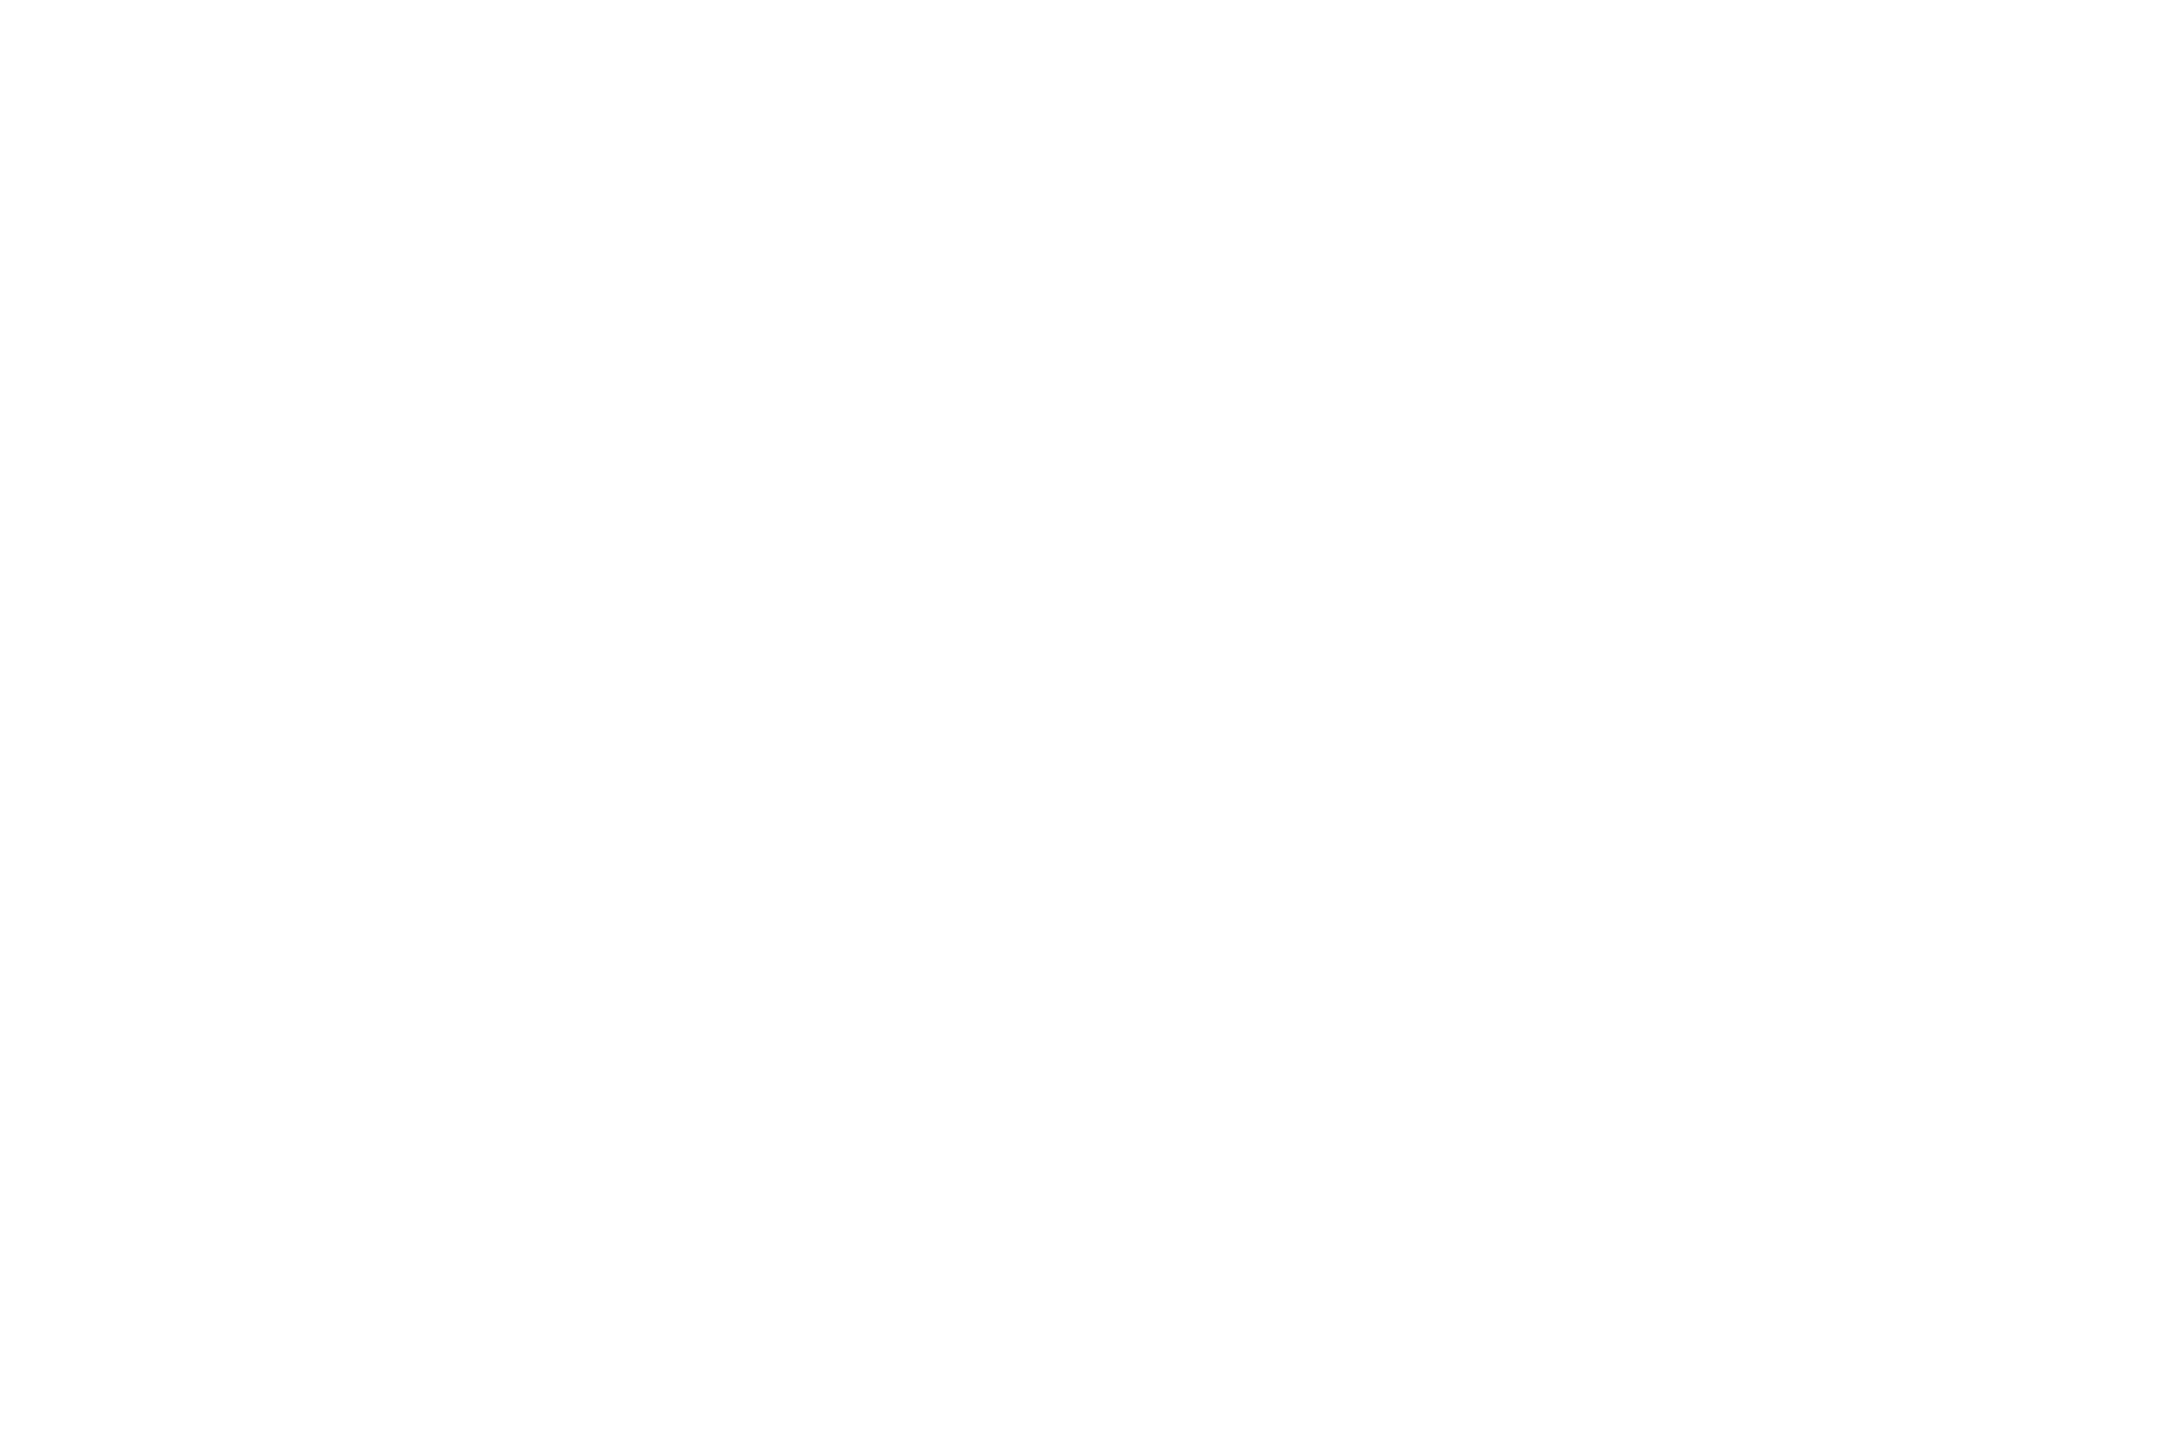

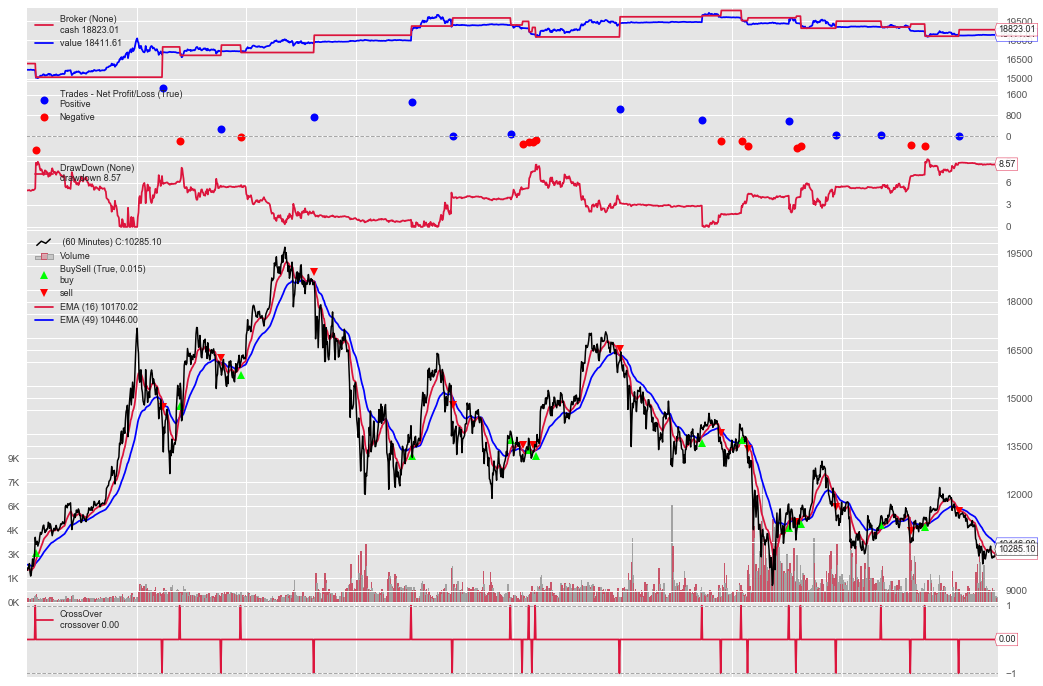

In [65]:
# Backtest with optimised parameters for simple EMA crossover on BTC / USDT

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('short_ema', 16),
        ('long_ema', 49),
        ('mult', 10),  # multiply profits and loses (margin trading)
        ('lever', 10),
        ('printlog', True),
        ('trailstoppct', 0.05),  # trailstop order trail 0.05 = 5%
    )


    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add exponential moving averages
        ema_short = bt.ind.EMA(period=self.params.short_ema)
        ema_long = bt.ind.EMA(period=self.params.long_ema)
        
        self.crossover = bt.ind.CrossOver(ema_short, ema_long)


    def next(self):
        
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:
            return  # if an order is active, no new orders are allowed
            
        if self.crossover > 0:  # cross upwards
            if self.position:
                self.log('CLOSE SHORT , %.2f' % self.dataclose[0])
                self.close()

            self.log('BUY CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.buy(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                    # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)

        elif self.crossover < 0:  # cross downwards
            if self.position:
                self.log('CLOSE LONG , %.2f' % self.dataclose[0])
                self.close()

            self.log('SELL CREATE , %.2f' % self.dataclose[0])
            # to make orders at 5% of portfolio value, no more than 500$
            self.sell(size=round(min((cerebro.broker.getvalue()*0.05), 500) / self.dataclose[0], 2))
                     # exectype=bt.Order.StopTrail, trailpercent=self.params.trailstoppct)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                         )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm)
                        )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=True)

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Acc Balance: %.2f' %
                 (trade.pnl, trade.pnlcomm, cerebro.broker.getvalue()))
        
        elif trade.justopened:
            self.log('TRADE OPENED, SIZE: %2d , VAL: %.2f' % (trade.size, trade.value))


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    # timeframe and compression tells the system we have hourly data
    data = bt.feeds.PandasData(dataname=btc_usdt1h,
                               timeframe=bt.TimeFrame.Minutes,
                               compression=60)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)  # 10,000

    # Set the commission
    cerebro.broker.setcommission(commission=0.001,  # 0.1% binance commission
                                 mult=TestStrategy.params.mult,
                                 interest=0.01,  # long/short interest 0.01 -> 1%
                                 leverage=TestStrategy.params.lever,
                                 interest_long=True
                                 )
    
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Create Analyzers
    # RF = 1%, 
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='mydrawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanal')
    cerebro.addanalyzer(bt.analyzers.BasicTradeStats , _name='tradestats')
    
    # Create Observers
    cerebro.addobserver(bt.observers.DrawDown)

    # Run over everything
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    
    # Print Analyzers
    print()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
    print()
    print('Annualised SharpeR:', thestrat.analyzers.mysharpe.get_analysis()['sharperatio'])
    print()
    # CAGR = (end bal / beg bal) ^ 1/n of years - 1
    print('CAGR % ', thestrat.analyzers.returns.get_analysis()['rnorm100'] * 100)
    print()
    printTradeAnalysis(thestrat.analyzers.mytradeanal.get_analysis())
    print()
    printDrawDown(thestrat.analyzers.mydrawdown.get_analysis())
    print()
    pprint.pprint(dict(thestrat.analyzers.tradestats.get_analysis()))
    
    # to plot part of the data
    cerebro.plot(start=datetime.date(2017, 12, 1), end=datetime.date(2018, 2, 1))
    
    # cerebro.plot()  # plot backtest

# The End